# Cell-Cell interaction Analysis using NCEM  
### Spatial pancreas  
Annotation of dissociated data from npod by Rebecca Melton - Gaulton's lab 

### Pre-requisites

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np

import scanpy as sc
import squidpy as sq
import ncem as nc

import matplotlib.pyplot as plt

sc.settings.set_figure_params(dpi=80, facecolor="white")

2024-08-27 15:11:27.221796: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-27 15:11:32.448828: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-27 15:11:40.229069: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-27 15:12:18.400080: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
nc.__version__

'0.1.5'

### Load data

In [3]:
folder = '/lustre/groups/ml01/workspace/sara.jimenez/spatial_pancreas_data/preprocessed_data/data4downstream/'
adata_10 = sc.read(folder+'adata_fov_10_npod_annotation_filtered.h5ad')
adata_12 = sc.read(folder+'adata_fov_12_npod_annotation_filtered.h5ad')
adata_10,adata_12

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


(AnnData object with n_obs × n_vars = 4423 × 979
     obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'CellTypes_max'
     var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
     uns: 'CellTypes_max_colors', 'cell_type_coarse_colors', 'log1p', 'neighbors', 'pca', 'spatial', 'umap'
     obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_fov'
     varm: 'PCs'
     layers: 'cou

In [4]:
adata_10.obs['CellTypes_max'].cat.categories

Index(['Acinar_basal', 'Acinar_highEnz', 'Acinar_sigdiff', 'Acinar_signal',
       'Activated_Stellate', 'Alpha', 'Beta', 'Delta', 'Ductal', 'Endothelial',
       'MUC5b_Ductal', 'Macrophage', 'Quiescent_Stellate', 'Tcells'],
      dtype='object')

In [5]:
adata_12.obs['CellTypes_max'].cat.categories

Index(['Acinar_basal', 'Acinar_highEnz', 'Acinar_sigdiff', 'Acinar_signal',
       'Activated_Stellate', 'Alpha', 'Beta', 'Delta', 'Ductal', 'Endothelial',
       'MUC5b_Ductal', 'Macrophage', 'Quiescent_Stellate', 'Tcells'],
      dtype='object')

In [6]:
CellTypes_max_10 = adata_10.obs['CellTypes_max']
CellTypes_max_12 = adata_12.obs['CellTypes_max']

new_order = ['Acinar_basal', 'Acinar_highEnz', 'Acinar_signal', 'Acinar_sigdiff', 'Ductal', 'MUC5b_Ductal',
             'Beta', 'Alpha', 'Delta', 'Activated_Stellate', 'Quiescent_Stellate', 'Endothelial', 
             'Macrophage', 'Tcells']

adata_10.obs['CellTypes_max'] = pd.Categorical(CellTypes_max_10, categories=new_order, ordered=True)
adata_12.obs['CellTypes_max'] = pd.Categorical(CellTypes_max_12, categories=new_order, ordered=True)


In [7]:
print(adata_10.obs['CellTypes_max'].cat.categories)

Index(['Acinar_basal', 'Acinar_highEnz', 'Acinar_signal', 'Acinar_sigdiff',
       'Ductal', 'MUC5b_Ductal', 'Beta', 'Alpha', 'Delta',
       'Activated_Stellate', 'Quiescent_Stellate', 'Endothelial', 'Macrophage',
       'Tcells'],
      dtype='object')


In [8]:
markers={
    'Acinar_basal':['REG1A'],
    #'Acinar_highEnz':['CTRB1'],#PRSS1
    'Acinar_signal':['SOD2'],
    'Acinar_sigdiff':['MT1X'],
    #'Ductal': ['CFTR'],
    #'MUC5b_Ductal':['MUC5B'],
    'Beta': ['INS'],
    'Alpha':['GCG'],
    'Delta': ['SST'],
    'Activated_Stellate':['COL6A3'],
    'Quiescent_Stellate': ['SPARCL1'],
    #'Endothelial':['PLVAP'],
    #'LymphEndo':['FLT4'],
    'Macrophage':['C1QB'],
    'Tcells': ['CD2'],
    #'Schwann': ['CDH19'],
    'Mast':['KIT'],
    'Bcells':['CD53']    
}

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/scanpy/plotting/_matrixplot.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


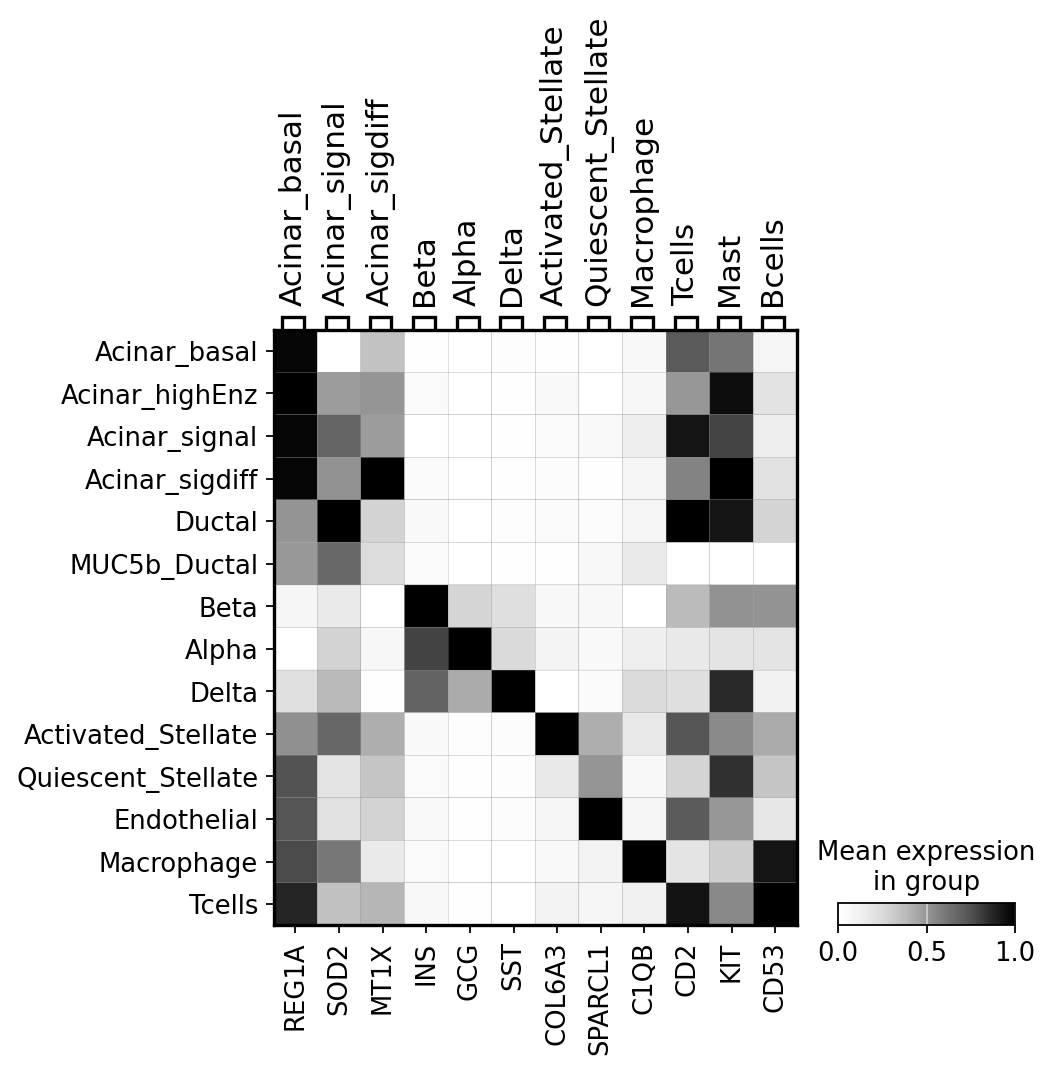

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/scanpy/plotting/_matrixplot.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


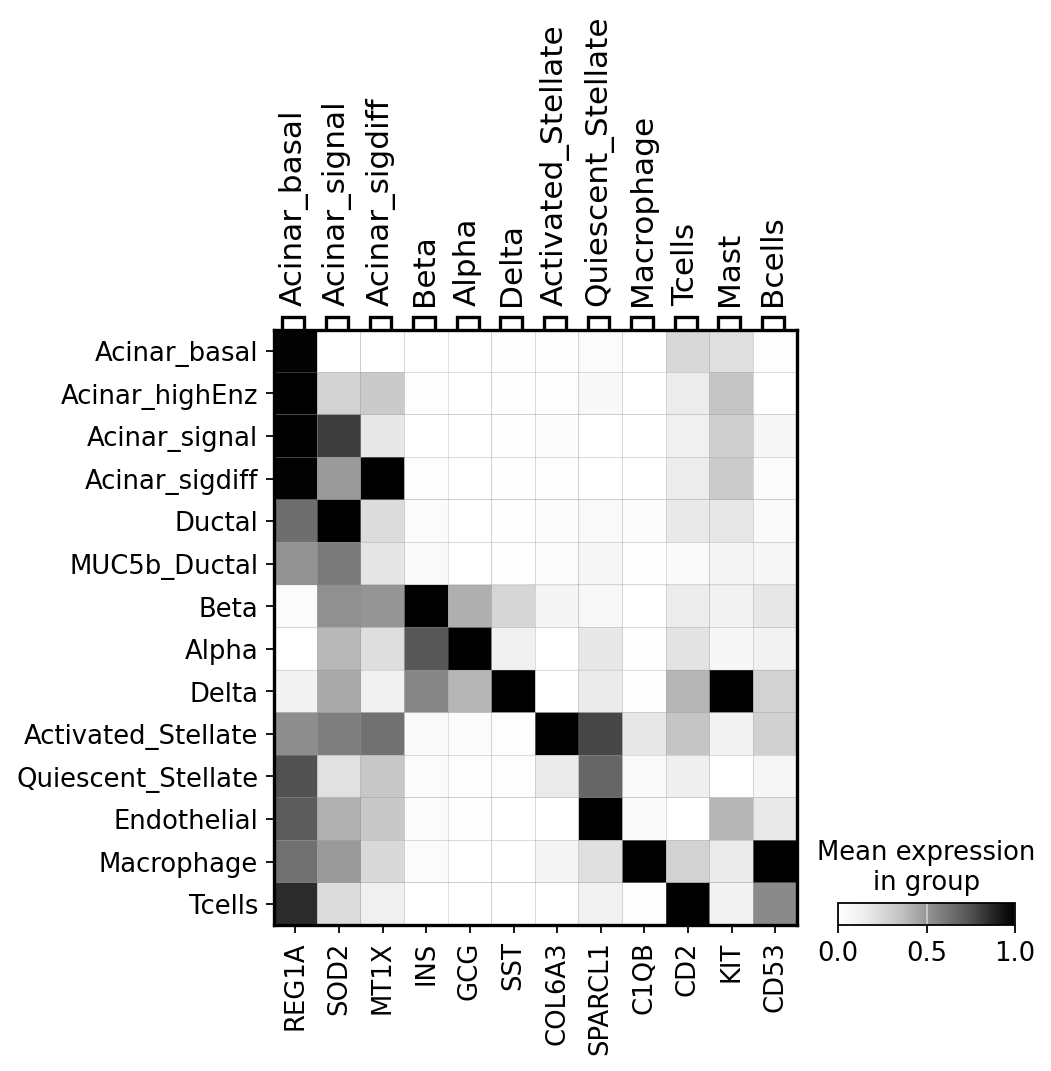

In [9]:
sc.pl.matrixplot(adata_10, markers,groupby='CellTypes_max', cmap='Greys',standard_scale='var')
sc.pl.matrixplot(adata_12, markers,groupby='CellTypes_max', cmap='Greys',standard_scale='var')

### Data Exploration

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is 

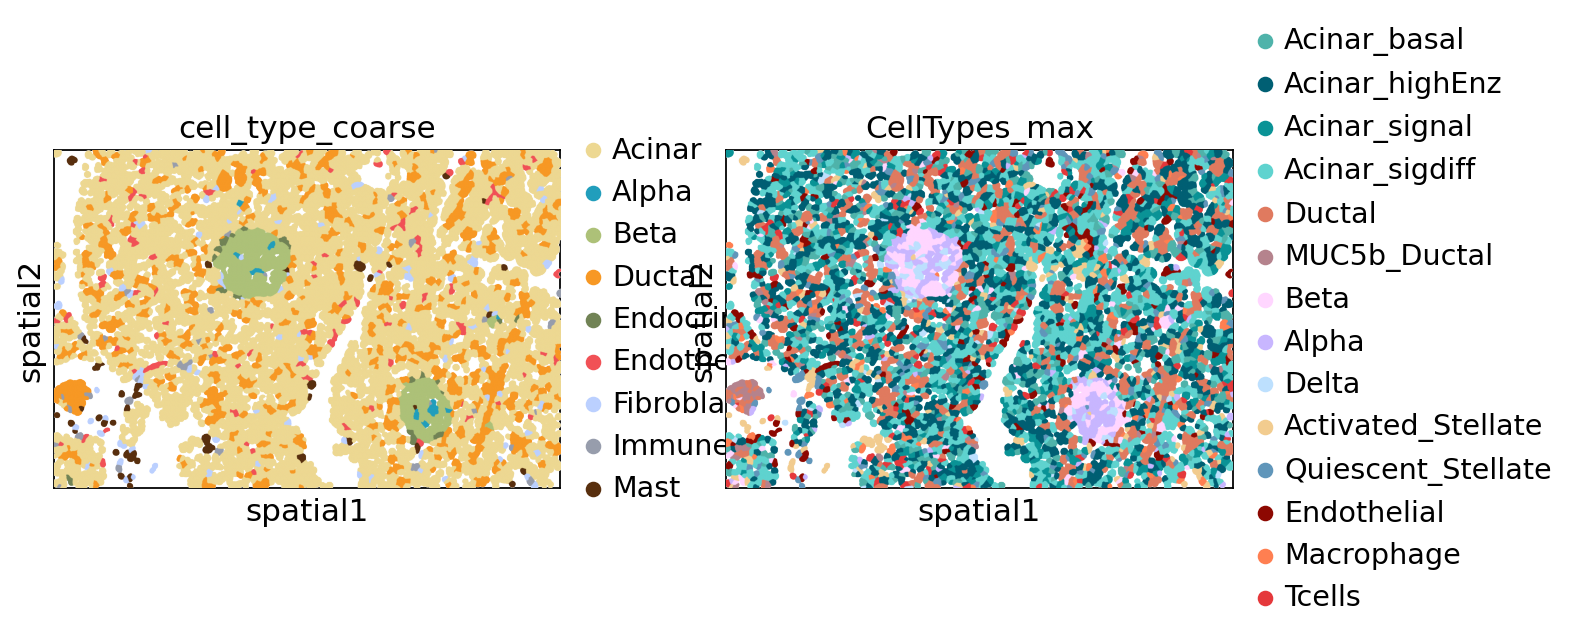

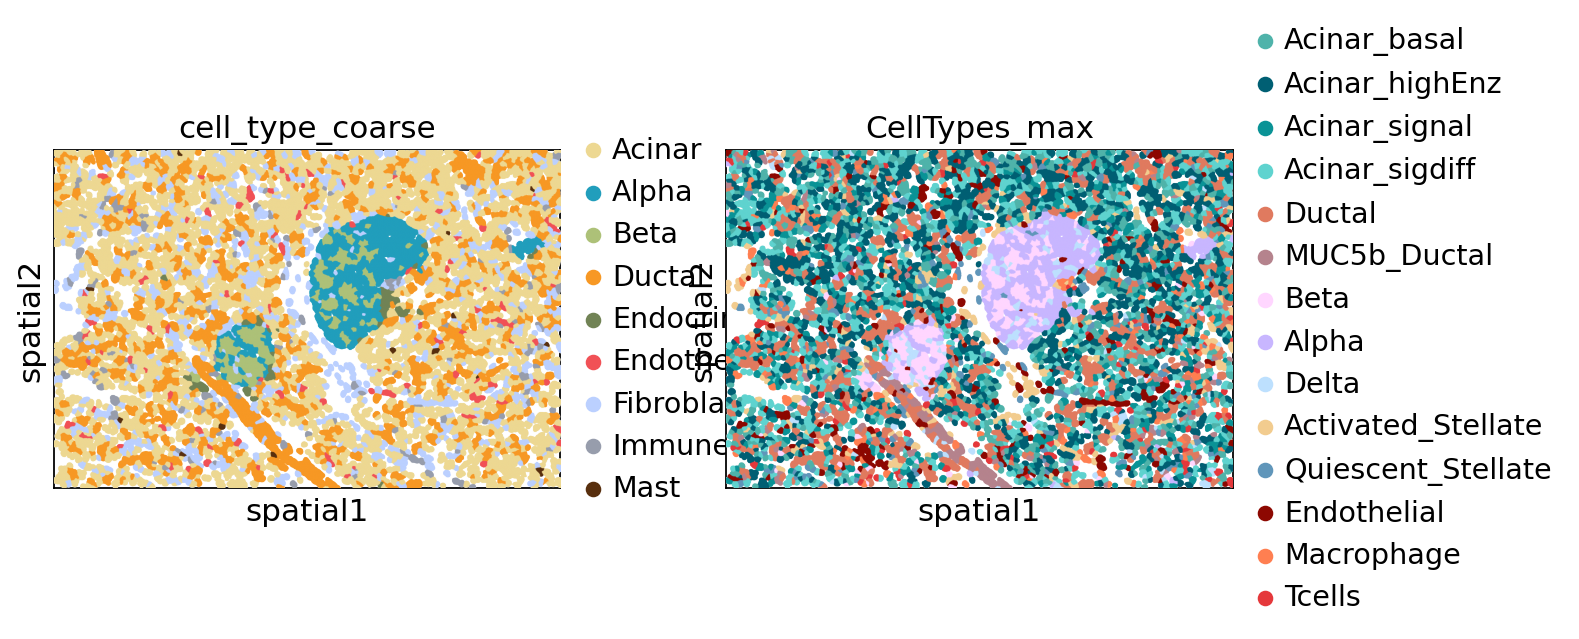

In [10]:
sq.pl.spatial_segment(adata_10,color=['cell_type_coarse','CellTypes_max'],ncols=2,library_key='fov',seg_cell_id='cell_ID',img=False)
sq.pl.spatial_segment(adata_12,color=['cell_type_coarse','CellTypes_max'],ncols=2,library_key='fov',seg_cell_id='cell_ID',img=False)

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)


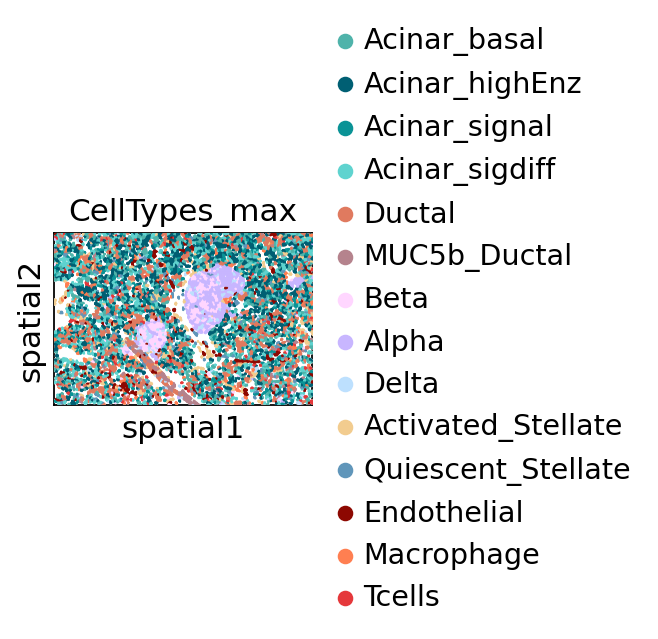

In [12]:
sq.pl.spatial_segment(adata_12,color=['CellTypes_max'],ncols=1,library_key='fov',seg_cell_id='cell_ID',img=False)

In [13]:
type(adata_10.X)

scipy.sparse._csr.csr_matrix

In [14]:
adata_10.X = adata_10.X.toarray()
adata_12.X = adata_12.X.toarray()

1. Noise distribution of the dataset per cell type 
- NCEM requires gaussian distribution not negative binomial 
- Important not to overnormalized -> the 

Acinar_basal
Acinar_highEnz
Acinar_sigdiff
Acinar_signal
Activated_Stellate
Alpha
Beta
Delta
Ductal
Endothelial
MUC5b_Ductal
Macrophage
Quiescent_Stellate
Tcells


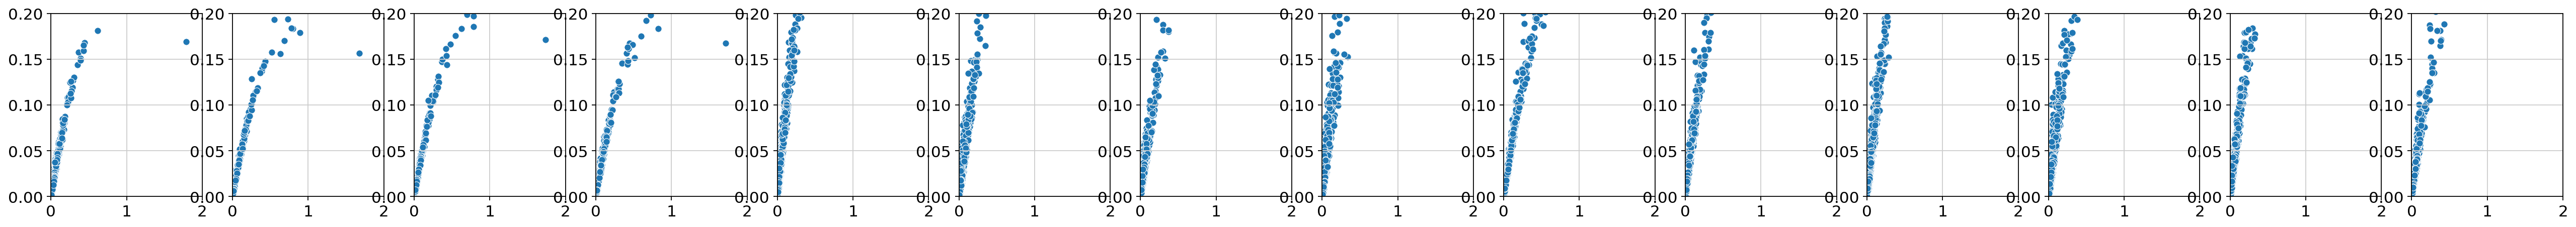

In [15]:
fig, ax = plt.subplots(1,len(np.unique(adata_10.obs['CellTypes_max'])), figsize=(40,3))
for i, ct in enumerate(np.unique(adata_10.obs['CellTypes_max'])):
    print(ct)
    mean = np.mean(adata_10[adata_10.obs['CellTypes_max']==ct].X, axis=0)
    var = np.var(adata_10[adata_10.obs['CellTypes_max']==ct].X, axis=0)
    g=sns.scatterplot(x=mean, y=var, ax=ax[i])
    g.set(ylim=(0, 0.2), xlim=(0,2))

Acinar_basal
Acinar_highEnz
Acinar_sigdiff
Acinar_signal
Activated_Stellate
Alpha
Beta
Delta
Ductal
Endothelial
MUC5b_Ductal
Macrophage
Quiescent_Stellate
Tcells


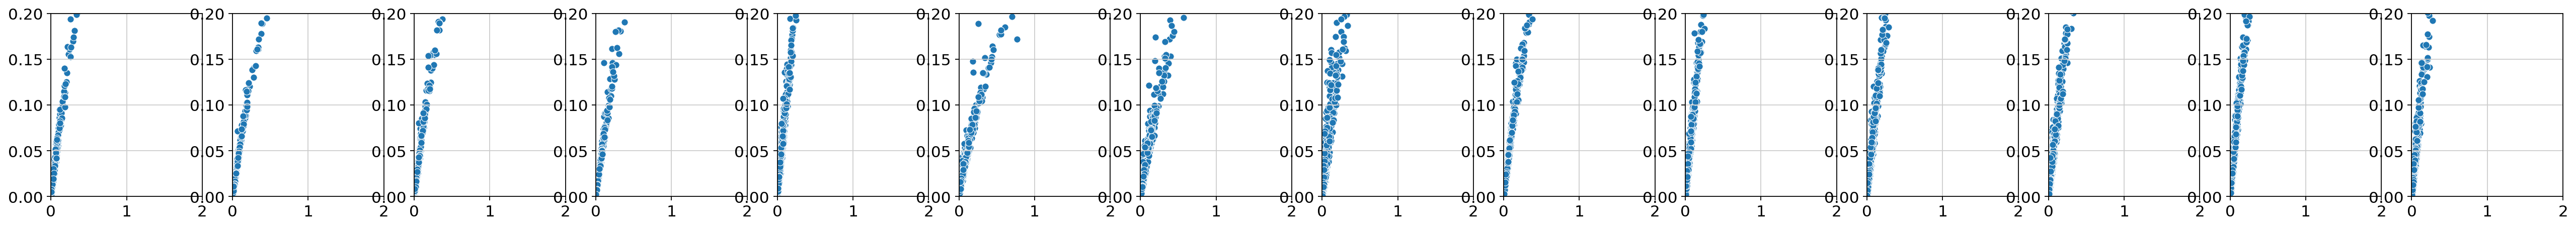

In [16]:
fig, ax = plt.subplots(1,len(np.unique(adata_12.obs['CellTypes_max'])), figsize=(40,3))
for i, ct in enumerate(np.unique(adata_12.obs['CellTypes_max'])):
    print(ct)
    mean = np.mean(adata_12[adata_12.obs['CellTypes_max']==ct].X, axis=0)
    var = np.var(adata_12[adata_12.obs['CellTypes_max']==ct].X, axis=0)
    g=sns.scatterplot(x=mean, y=var, ax=ax[i])
    g.set(ylim=(0, 0.2), xlim=(0,2))

### Pre-processing

In [17]:
adata_10.X.max(),adata_12.X.max()

(4.3824596, 4.3965755)

In [18]:
adata_10.layers['counts'].max(),adata_12.layers['counts'].max()

(226, 177)

#### the data seems normalized
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
adata.X

In [19]:
sq.gr.spatial_neighbors(
    adata_10,
    n_neighs=50,
    coord_type="generic",
    delaunay=True,
    library_key='fov'
)

sq.gr.spatial_neighbors(
    adata_12,
    n_neighs=50,
    coord_type="generic",
    delaunay=True,
    library_key='fov'
)

### Neighbors enrichment analysis

In [20]:
sq.gr.nhood_enrichment(adata_10,cluster_key='CellTypes_max')
sq.gr.nhood_enrichment(adata_12,cluster_key='CellTypes_max')

100%|██████████| 1000/1000 [00:00<00:00, 1509.08/s]


/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_utils.py:557: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_labels = adata.obs[key][row_order]
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_utils.py:557: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be trea

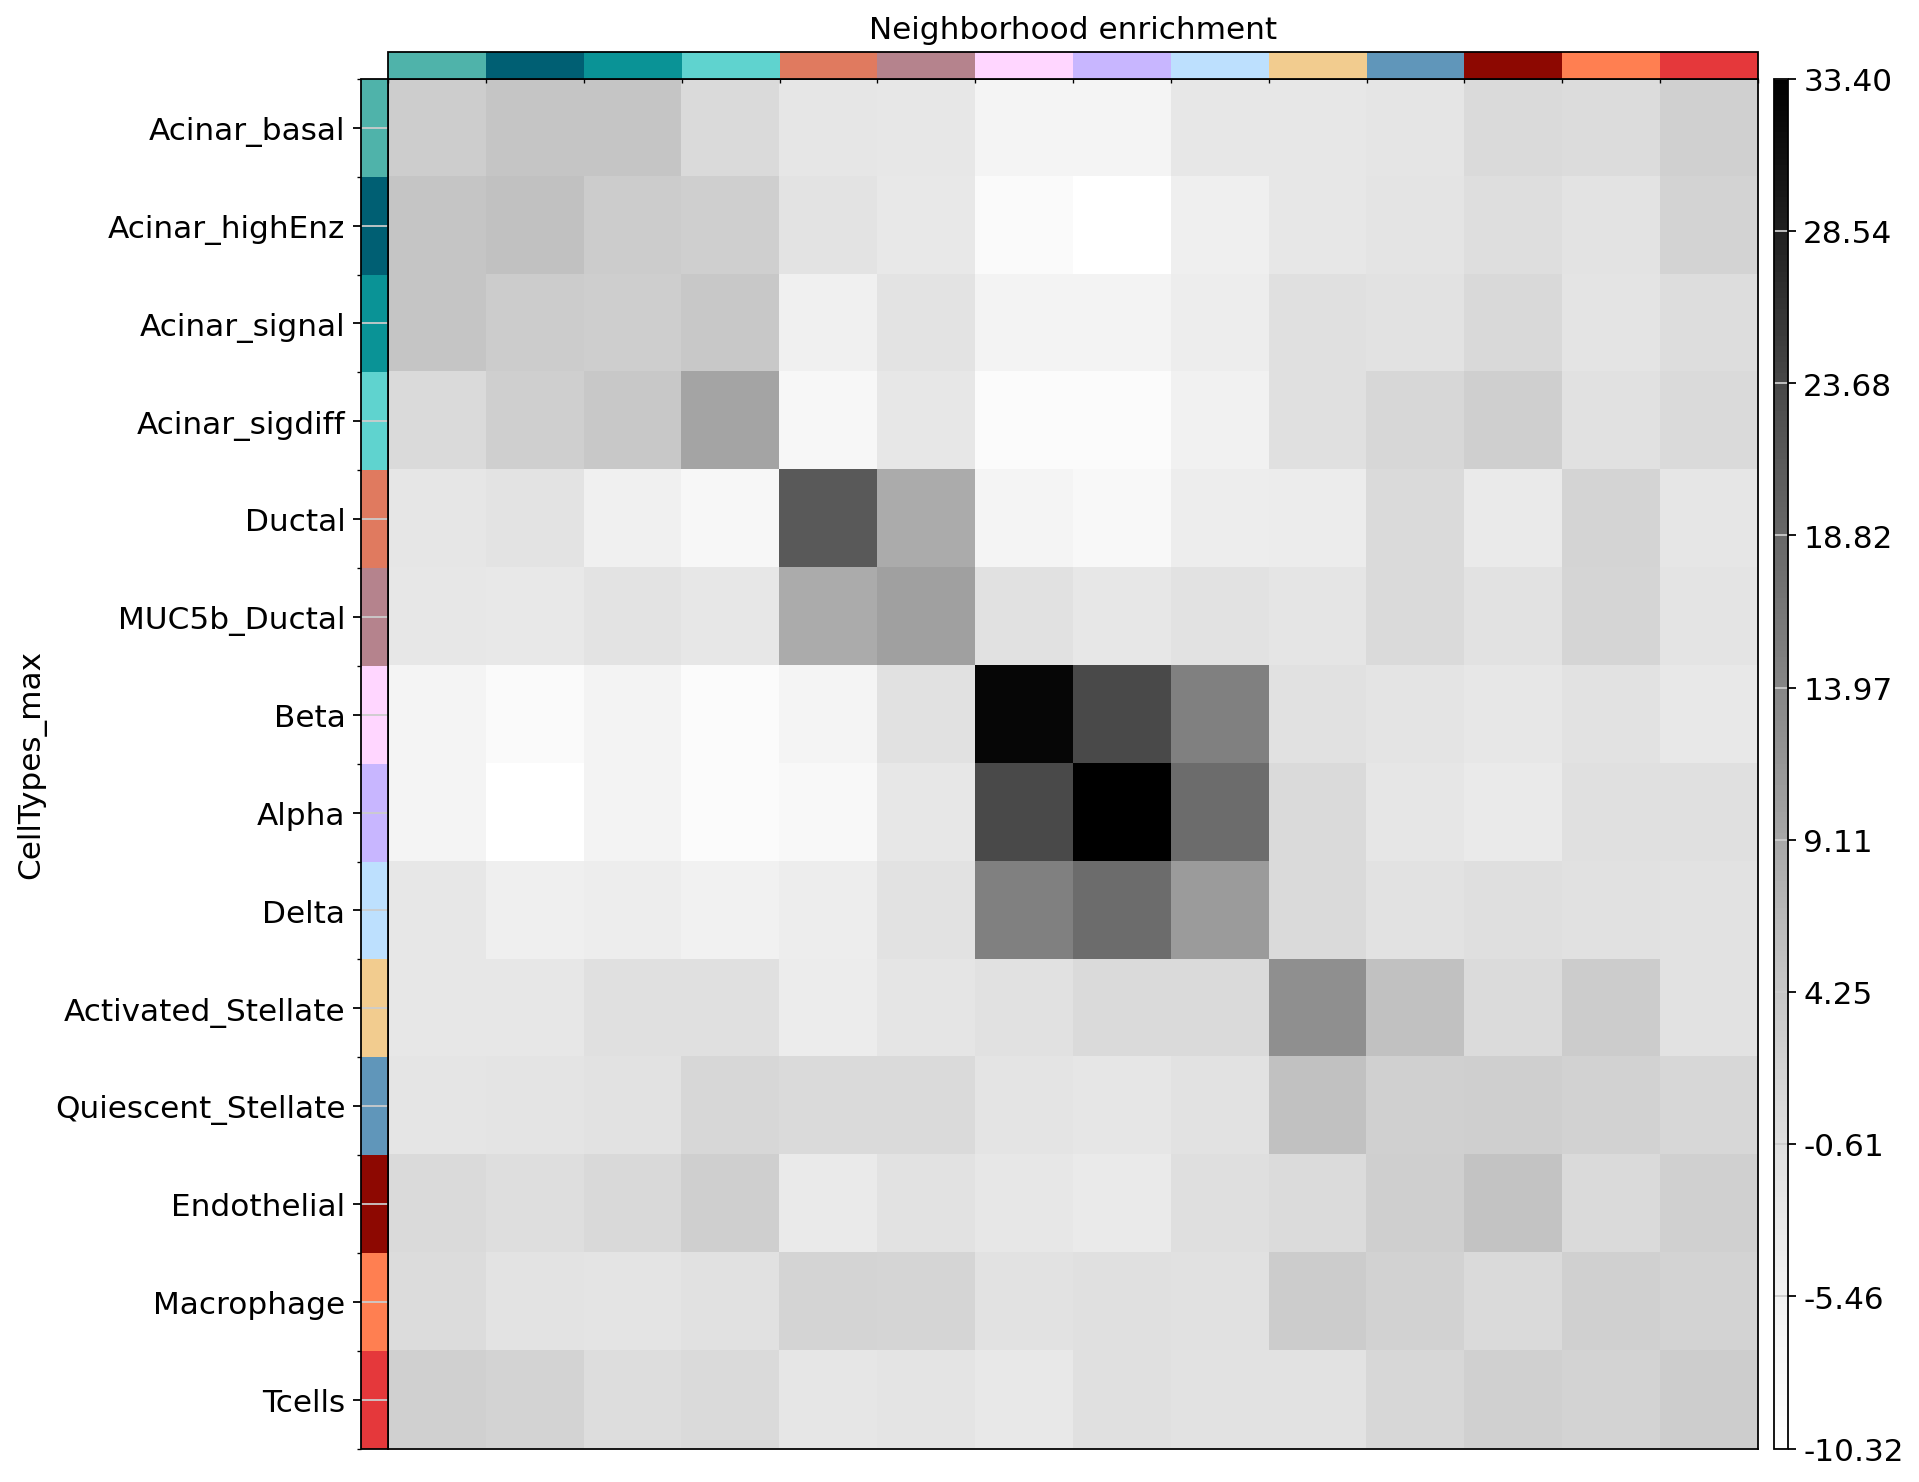

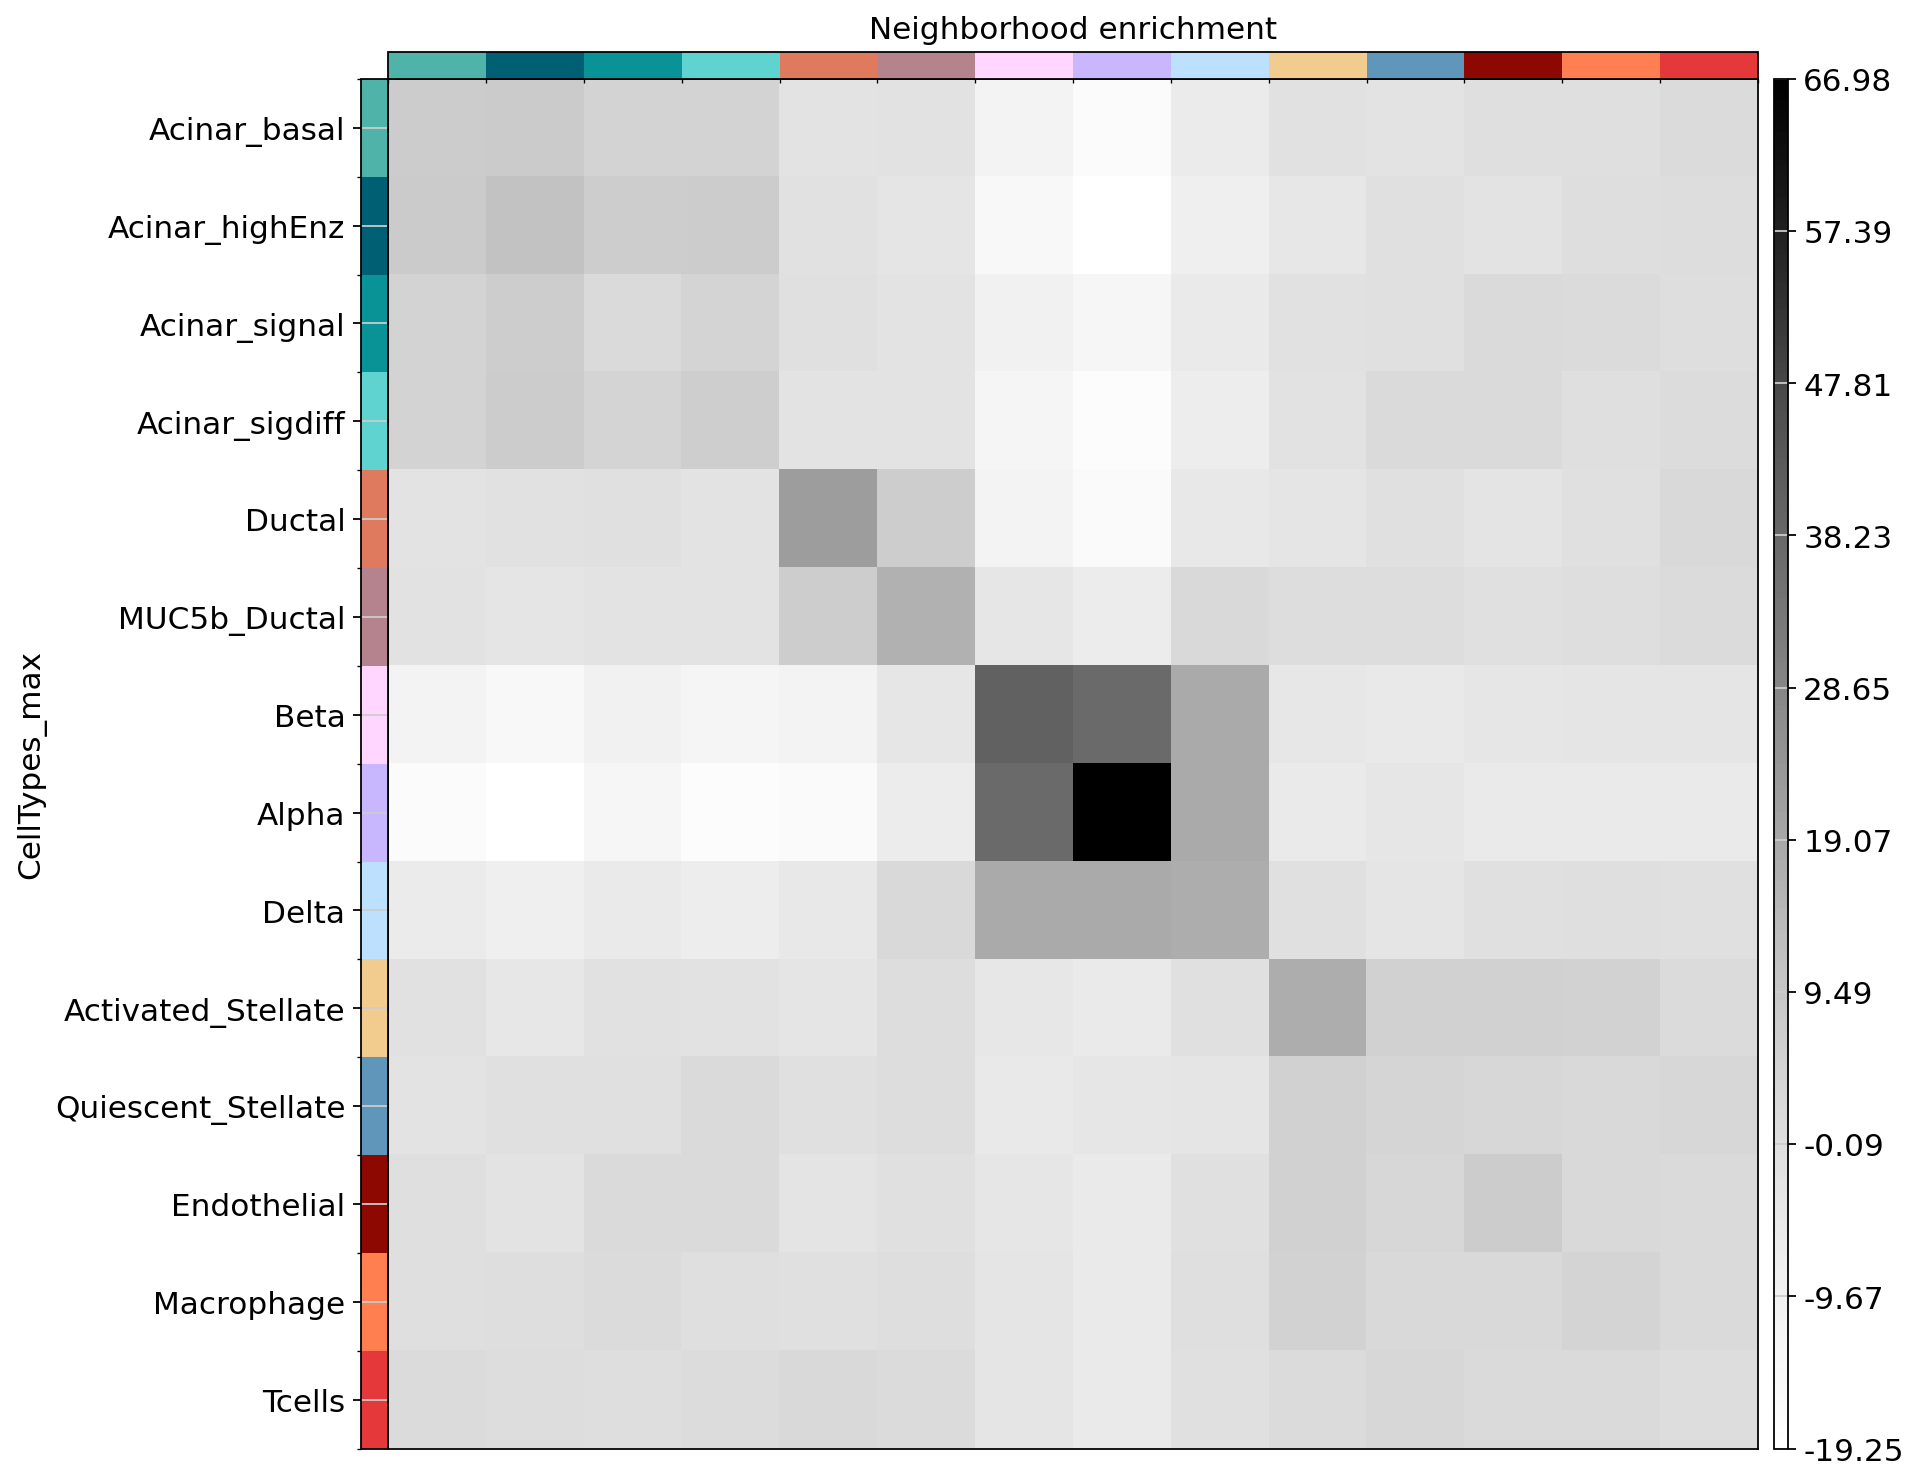

In [21]:
sq.pl.nhood_enrichment(adata_10, cluster_key='CellTypes_max',cmap='Greys')
sq.pl.nhood_enrichment(adata_12, cluster_key='CellTypes_max',cmap='Greys')

In [22]:
sq.gr.interaction_matrix(adata_10, cluster_key='CellTypes_max',weights=True)
sq.gr.interaction_matrix(adata_12, cluster_key='CellTypes_max',weights=True)

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_utils.py:557: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_labels = adata.obs[key][row_order]
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_utils.py:557: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be trea

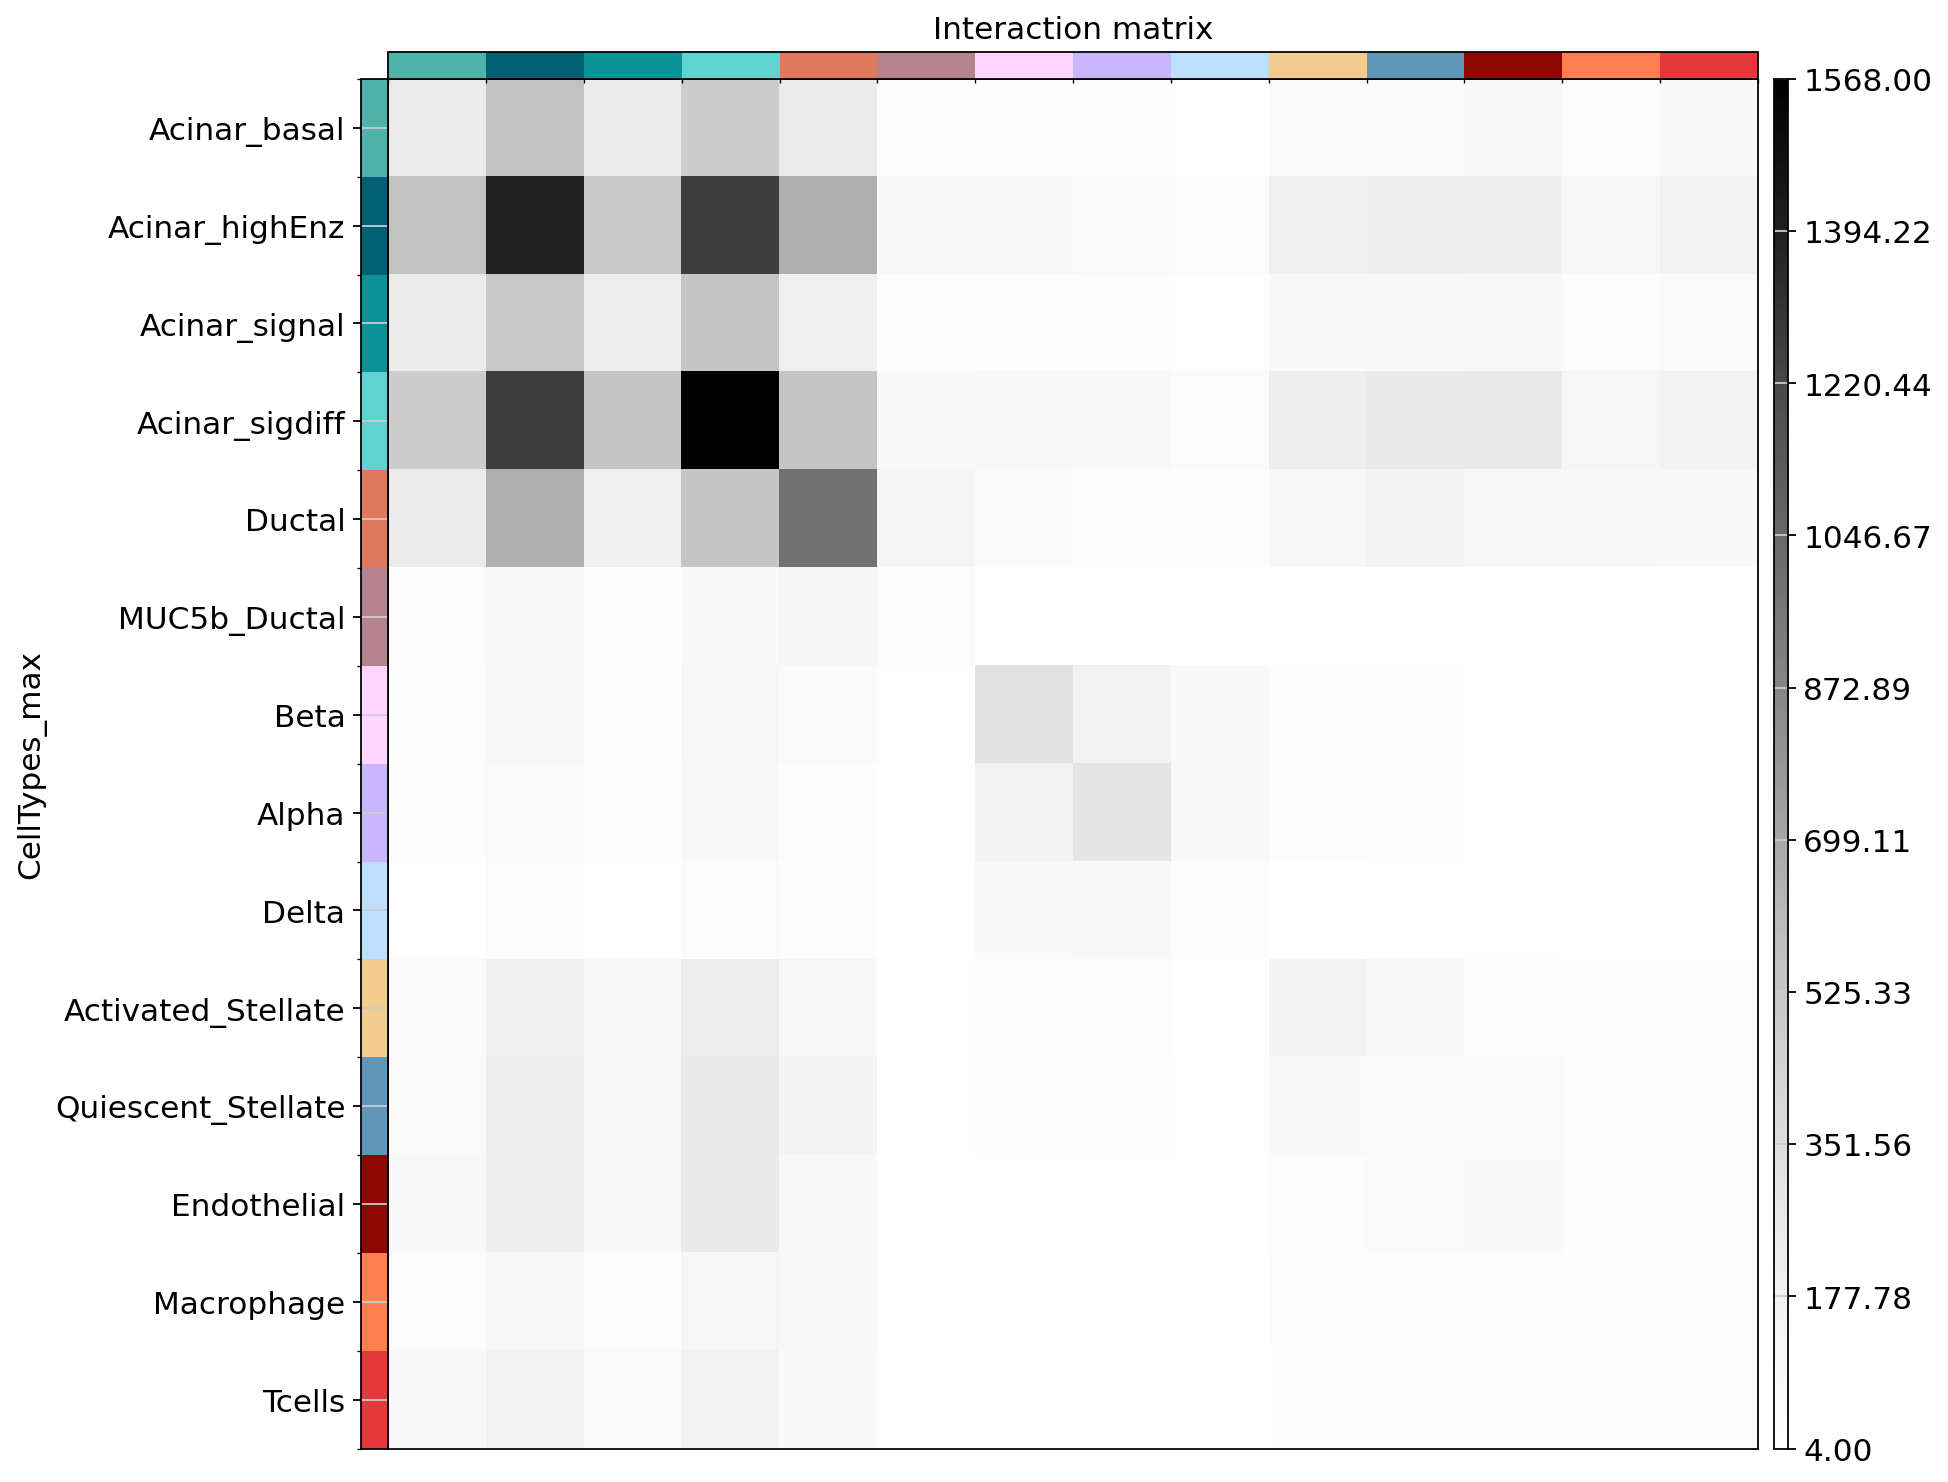

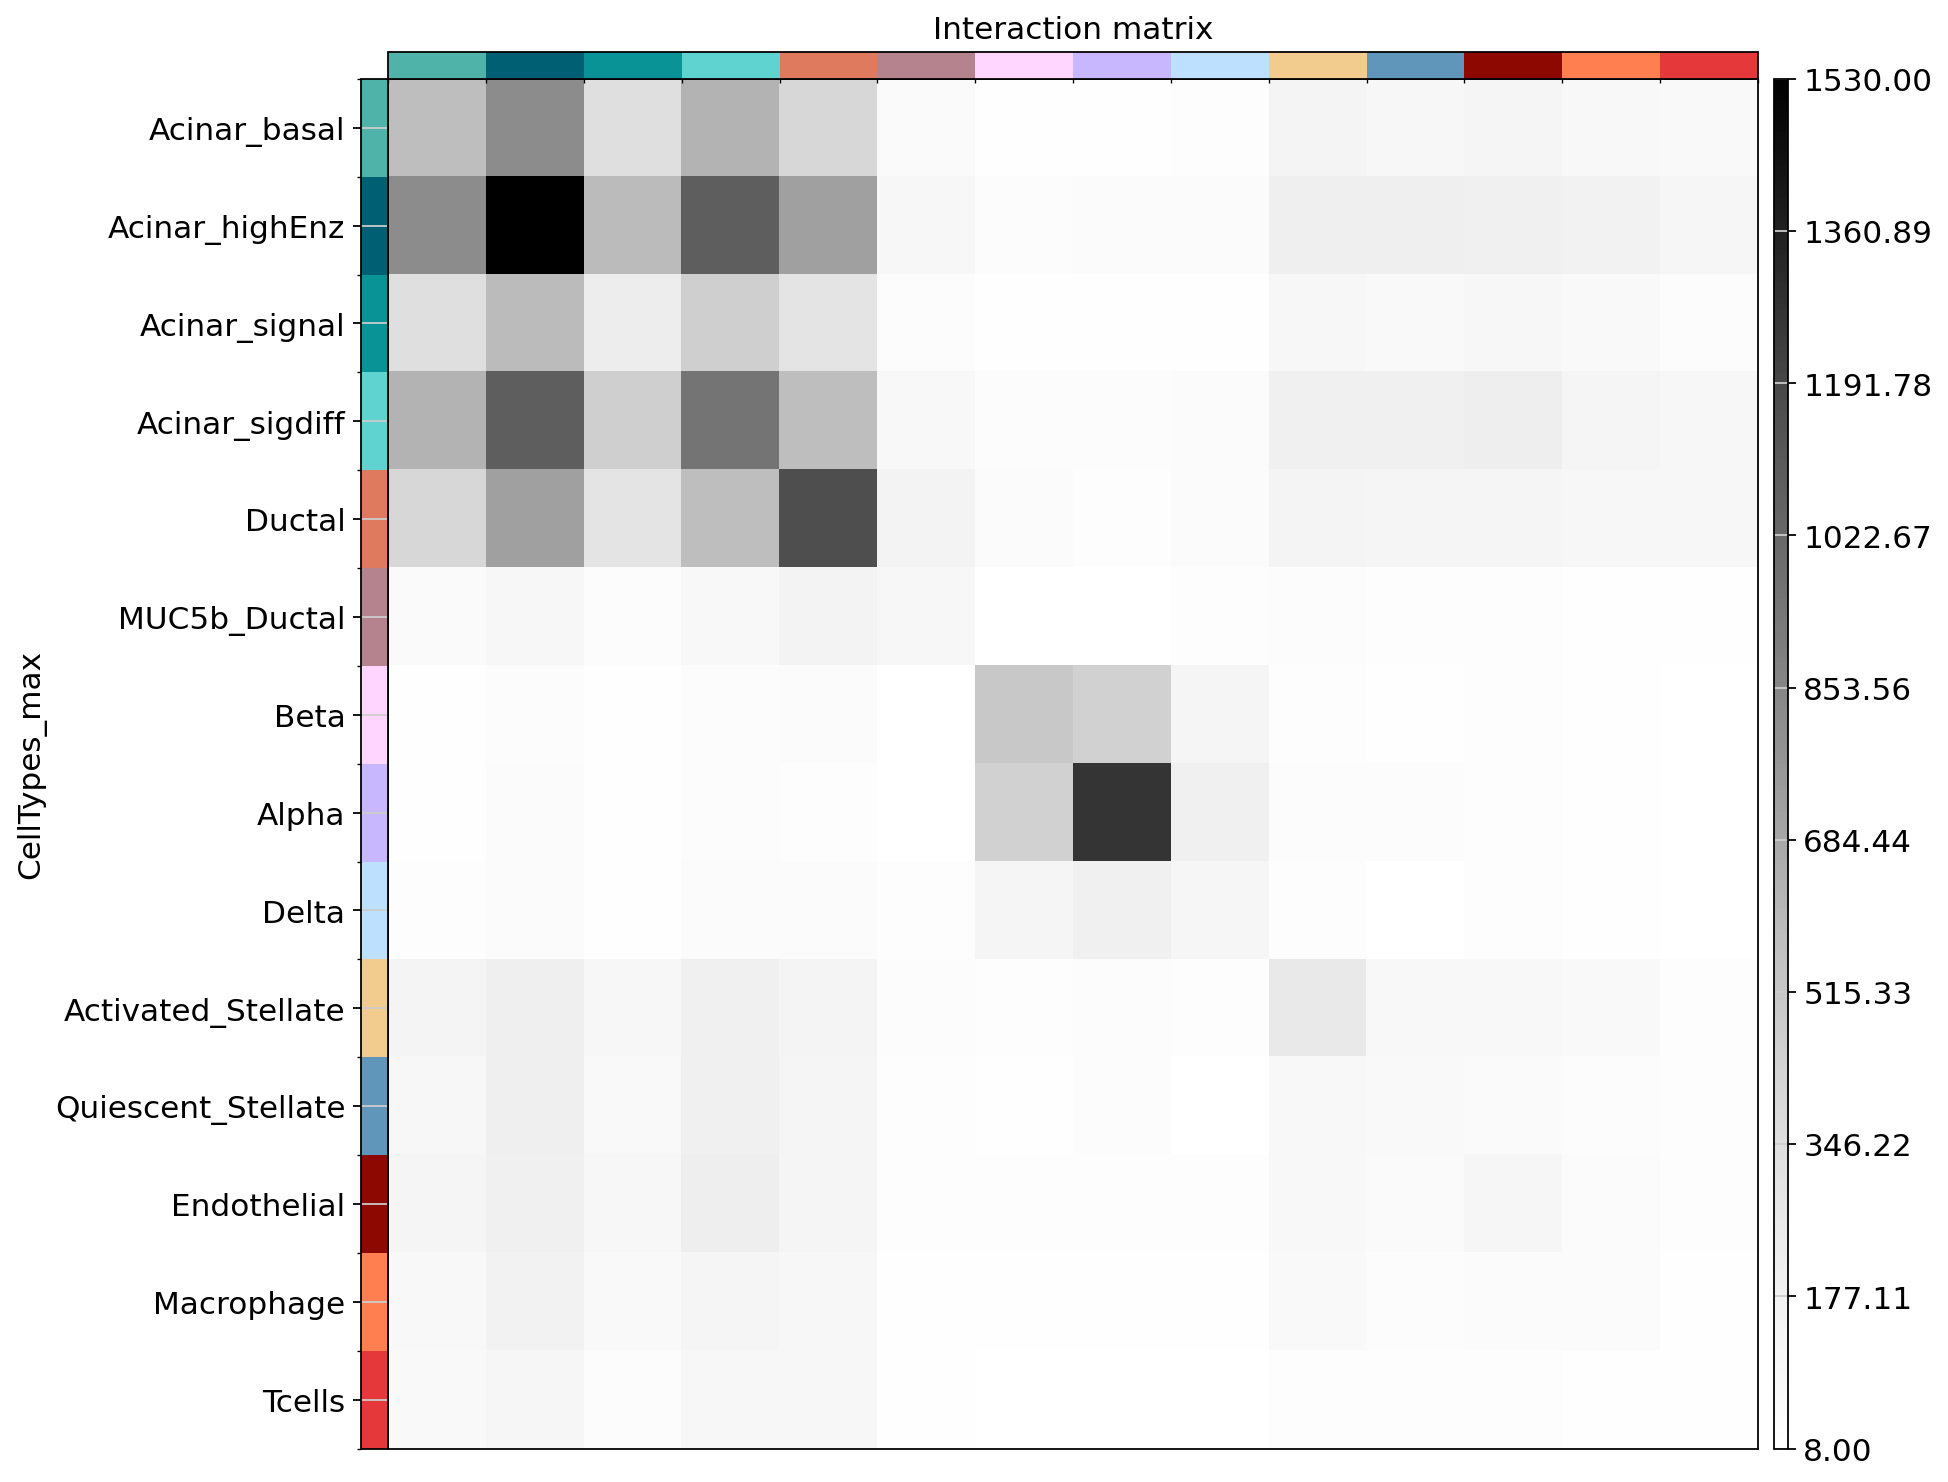

In [23]:
sq.pl.interaction_matrix(adata_10, cluster_key='CellTypes_max',cmap='Greys')
sq.pl.interaction_matrix(adata_12, cluster_key='CellTypes_max',cmap='Greys')

### Moran’s I score

The Moran’s I global spatial auto-correlation statistics evaluates whether features (i.e. genes) shows a pattern that is clustered, dispersed or random in the tissue are under consideration.

In [39]:
#sq.gr.spatial_neighbors(adata, coord_type="generic", delaunay=True)
sq.gr.spatial_autocorr(
    adata_10,
    mode="moran",
    n_perms=100,
    n_jobs=1,
)
adata_10.uns["moranI"].head(10)

100%|██████████| 100/100 [00:20<00:00,  4.89/s]


I  pval_norm  var_norm  pval_z_sim  pval_sim   var_sim  \
INS     0.760236        0.0  0.000077         0.0  0.009901  0.000152   
TTR     0.690693        0.0  0.000077         0.0  0.009901  0.000165   
GCG     0.672162        0.0  0.000077         0.0  0.009901  0.000152   
PRSS2   0.630984        0.0  0.000077         0.0  0.009901  0.000144   
CHGA    0.624503        0.0  0.000077         0.0  0.009901  0.000126   
REG1A   0.603012        0.0  0.000077         0.0  0.009901  0.000121   
CPB1    0.577031        0.0  0.000077         0.0  0.009901  0.000137   
IAPP    0.543026        0.0  0.000077         0.0  0.009901  0.000123   
SST     0.498951        0.0  0.000077         0.0  0.009901  0.000113   
SPINK1  0.458825        0.0  0.000077         0.0  0.009901  0.000131   

        pval_norm_fdr_bh  pval_z_sim_fdr_bh  pval_sim_fdr_bh  
INS                  0.0                0.0         0.038928  
TTR                  0.0                0.0         0.038928  
GCG                  0.0                0.0         0.038928  
PRSS2                0.0                0.0         0.038928  
CHGA                 0.0                0.0         0.038928  
REG1A                0.0                0.0         0.038928  
CPB1                 0.0                0.0         0.038928  
IAPP                 0.0                0.0         0.038928  
SST                  0.0                0.0         0.038928  
SPINK1               0.0                0.0         0.038928

In [49]:
#sq.gr.spatial_neighbors(adata, coord_type="generic", delaunay=True)
sq.gr.spatial_autocorr(
    adata_12,
    mode="moran",
    n_perms=100,
    n_jobs=1,
)
adata_12.uns["moranI"].head(50)

100%|██████████| 100/100 [00:25<00:00,  3.88/s]


I  pval_norm  var_norm  pval_z_sim  pval_sim   var_sim  \
TTR       0.841436        0.0  0.000065         0.0  0.009901  0.000161   
GCG       0.813863        0.0  0.000065         0.0  0.009901  0.000157   
CHGA      0.765895        0.0  0.000065         0.0  0.009901  0.000138   
INS       0.757733        0.0  0.000065         0.0  0.009901  0.000162   
PRSS2     0.732667        0.0  0.000065         0.0  0.009901  0.000146   
REG1A     0.714490        0.0  0.000065         0.0  0.009901  0.000130   
CPB1      0.674632        0.0  0.000065         0.0  0.009901  0.000146   
SPINK1    0.551265        0.0  0.000065         0.0  0.009901  0.000123   
IAPP      0.515339        0.0  0.000065         0.0  0.009901  0.000091   
SCG5      0.422968        0.0  0.000065         0.0  0.009901  0.000092   
SST       0.409657        0.0  0.000065         0.0  0.009901  0.000107   
HLA-A     0.379748        0.0  0.000065         0.0  0.009901  0.000102   
G6PC2     0.371600        0.0  0.000065         0.0  0.009901  0.000073   
GC        0.358279        0.0  0.000065         0.0  0.009901  0.000075   
OLFM4     0.312706        0.0  0.000065         0.0  0.009901  0.000067   
SERPINA3  0.312608        0.0  0.000065         0.0  0.009901  0.000087   
TIMP1     0.253259        0.0  0.000065         0.0  0.009901  0.000084   
SERPINA1  0.251805        0.0  0.000065         0.0  0.009901  0.000065   
MEG3      0.216632        0.0  0.000065         0.0  0.009901  0.000049   
CALM1     0.207752        0.0  0.000065         0.0  0.009901  0.000066   
ANXA4     0.196152        0.0  0.000065         0.0  0.009901  0.000039   
CUZD1     0.192095        0.0  0.000065         0.0  0.009901  0.000073   
MZT2A     0.187667        0.0  0.000065         0.0  0.009901  0.000056   
CLU       0.185050        0.0  0.000065         0.0  0.009901  0.000054   
MIF       0.183529        0.0  0.000065         0.0  0.009901  0.000054   
B2M       0.181528        0.0  0.000065         0.0  0.009901  0.000063   
FOS       0.177653        0.0  0.000065         0.0  0.009901  0.000058   
GSN       0.176955        0.0  0.000065         0.0  0.009901  0.000063   
HLA-C     0.174563        0.0  0.000065         0.0  0.009901  0.000047   
KRT8      0.160763        0.0  0.000065         0.0  0.009901  0.000046   
SOD2      0.160204        0.0  0.000065         0.0  0.009901  0.000038   
GPX3      0.147575        0.0  0.000065         0.0  0.009901  0.000052   
TYK2      0.138476        0.0  0.000065         0.0  0.009901  0.000060   
MALAT1    0.137195        0.0  0.000065         0.0  0.009901  0.000056   
CASR      0.134170        0.0  0.000065         0.0  0.009901  0.000055   
APOD      0.131242        0.0  0.000065         0.0  0.009901  0.000055   
FGFR3     0.128261        0.0  0.000065         0.0  0.009901  0.000053   
ZFP36     0.125585        0.0  0.000065         0.0  0.009901  0.000049   
KRT7      0.123177        0.0  0.000065         0.0  0.009901  0.000049   
AZU1      0.120858        0.0  0.000065         0.0  0.009901  0.000053   
MGP       0.120499        0.0  0.000065         0.0  0.009901  0.000048   
DDR1      0.118805        0.0  0.000065         0.0  0.009901  0.000043   
BMP5      0.118719        0.0  0.000065         0.0  0.009901  0.000064   
CALM2     0.117341        0.0  0.000065         0.0  0.009901  0.000060   
ANXA2     0.114521        0.0  0.000065         0.0  0.009901  0.000041   
KRT19     0.112346        0.0  0.000065         0.0  0.009901  0.000056   
RGS2      0.111413        0.0  0.000065         0.0  0.009901  0.000047   
COL6A2    0.110469        0.0  0.000065         0.0  0.009901  0.000046   
IGFBP7    0.109133        0.0  0.000065         0.0  0.009901  0.000046   
VEGFA     0.105096        0.0  0.000065         0.0  0.009901  0.000040   

          pval_norm_fdr_bh  pval_z_sim_fdr_bh  pval_sim_fdr_bh  
TTR                    0.0                0.0         0.027382  
GCG                    0.0                0.0         0.02738

In [50]:
adata_12.uns["moranI"].head(50).index.values

array(['TTR', 'GCG', 'CHGA', 'INS', 'PRSS2', 'REG1A', 'CPB1', 'SPINK1',
       'IAPP', 'SCG5', 'SST', 'HLA-A', 'G6PC2', 'GC', 'OLFM4', 'SERPINA3',
       'TIMP1', 'SERPINA1', 'MEG3', 'CALM1', 'ANXA4', 'CUZD1', 'MZT2A',
       'CLU', 'MIF', 'B2M', 'FOS', 'GSN', 'HLA-C', 'KRT8', 'SOD2', 'GPX3',
       'TYK2', 'MALAT1', 'CASR', 'APOD', 'FGFR3', 'ZFP36', 'KRT7', 'AZU1',
       'MGP', 'DDR1', 'BMP5', 'CALM2', 'ANXA2', 'KRT19', 'RGS2', 'COL6A2',
       'IGFBP7', 'VEGFA'], dtype=object)

In [52]:
# Assuming 'adata' is your AnnData object
genes = adata_12.uns["moranI"].to_csv("genes.txt", sep="\t")

In [ ]:
adata.obs.cell_type_coarse.value_counts()

In [ ]:
sc.pl.matrixplot(adata, adata.uns["moranI"].head(10).index.values, groupby='cell_type_coarse', cmap='Greys')
#mp.add_totals().style(edge_color='black').show()

In [ ]:
sq.pl.spatial_segment(
    adata,
    library_id="10",
    seg_cell_id="cell_ID",
    library_key="fov",
    color=["GCG", "INS", "CPB1","SPINK1"],
    size=60,
    img=False,cmap="RdYlBu_r"
)

### Ligand receptor analysis

In [26]:
adata_10.obs.CellTypes_max.cat.categories

Index(['Acinar_basal', 'Acinar_highEnz', 'Acinar_signal', 'Acinar_sigdiff',
       'Ductal', 'MUC5b_Ductal', 'Beta', 'Alpha', 'Delta',
       'Activated_Stellate', 'Quiescent_Stellate', 'Endothelial', 'Macrophage',
       'Tcells'],
      dtype='object')

In [32]:
sq.gr.ligrec(adata_10,cluster_key='CellTypes_max',#clusters=['Beta','Alpha','Delta','Acinar_highEnz','Macrophage','Tcells'],
             use_raw=False, alpha=0.001, complex_policy='min')
sq.gr.ligrec(adata_12,cluster_key='CellTypes_max',#clusters=['Beta','Alpha','Delta','Acinar_highEnz','Macrophage','Tcells'],
             use_raw=False, alpha=0.001, complex_policy='min')

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:733: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = data.groupby("clusters")
100%|██████████| 1000/1000 [00:03<00:00, 287.09permutation/s]
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:733: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = data.groupby("clusters")
100%|██████████| 1000/1000 [00:04<00:00, 242.98permutation/s]


In [35]:
res_10 = sq.gr.ligrec(
    adata_10,
    n_perms=1000,
    cluster_key="CellTypes_max",
    copy=True,
    use_raw=False,
    transmitter_params={"categories": "ligand"},
    receiver_params={"categories": "receptor"},
)

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:733: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = data.groupby("clusters")
100%|██████████| 1000/1000 [00:03<00:00, 281.91permutation/s]


In [37]:
res_10["metadata"].head()

aspect_intercell_source aspect_intercell_target  \
source target                                                   
EPOR   JAK2                functional              functional   
DLL1   NOTCH1              functional              functional   
IGF1   IGF1R               functional              functional   
CCL2   MMP14               functional              functional   
JAG1   NOTCH1              functional              functional   

              category_intercell_source category_intercell_target  \
source target                                                       
EPOR   JAK2                      ligand                  receptor   
DLL1   NOTCH1                    ligand                  receptor   
IGF1   IGF1R                     ligand                  receptor   
CCL2   MMP14                     ligand                  receptor   
JAG1   NOTCH1                    ligand                  receptor   

              category_source_intercell_source  \
source target                                    
EPOR   JAK2                  resource_specific   
DLL1   NOTCH1                resource_specific   
IGF1   IGF1R                 resource_specific   
CCL2   MMP14                 resource_specific   
JAG1   NOTCH1                resource_specific   

              category_source_intercell_target  consensus_direction  \
source target                                                         
EPOR   JAK2                  resource_specific                False   
DLL1   NOTCH1                resource_specific                 True   
IGF1   IGF1R                 resource_specific                 True   
CCL2   MMP14                 resource_specific                 True   
JAG1   NOTCH1                resource_specific                 True   

               consensus_inhibition  consensus_score_intercell_source  \
source target                                                           
EPOR   JAK2                   False                                 1   
DLL1   NOTCH1                 False                                11   
IGF1   IGF1R                  False                                21   
CCL2   MMP14                  False                                19   
JAG1   NOTCH1                 False                                13   

               consensus_score_intercell_target  ...  scope_intercell_source  \
source target                                    ...                           
EPOR   JAK2                                   1  ...                 generic   
DLL1   NOTCH1                                21  ...                 generic   
IGF1   IGF1R                                 22  ...                 generic   
CCL2   MMP14                                  1  ...                 generic   
JAG1   NOTCH1                                21  ...                 generic   

               scope_intercell_target secreted_intercell_source  \
source target                                                     
EPOR   JAK2                   generic                      True   
DLL1   NOTCH1                 generic                     False   
IGF1   IGF1R                  generic                      True   
CCL2   MMP14                  generic                      True   
JAG1   NOTCH1                 generic                     False   

              secreted_intercell_target  \
source target                             
EPOR   JAK2                       False   
DLL1   NOTCH1                     False   
IGF1   IGF1R                      False   
CCL2   MMP14                      False   
JAG1   NOTCH1                     False   

                                                         sources  \
source target                                                      
EPOR   JAK2    BioGRID;Cui2007;HPRD;KEGG-MEDICUS;SignaLink3;Wang   
DLL1   NOTCH1  Baccin2019;CellCall;CellChatDB;CellPhoneDB;Cel...   
IGF1   IGF1R   Baccin2019;CA1;CellCall;CellChatDB;CellPhoneDB...   
CCL2   MMP14                            

In [36]:
res_12 = sq.gr.ligrec(
    adata_12,
    n_perms=1000,
    cluster_key="CellTypes_max",
    copy=True,
    use_raw=False,
    transmitter_params={"categories": "ligand"},
    receiver_params={"categories": "receptor"},
)

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:733: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = data.groupby("clusters")
100%|██████████| 1000/1000 [00:03<00:00, 294.90permutation/s]


In [38]:
res_12["metadata"].head()

aspect_intercell_source aspect_intercell_target  \
source target                                                   
EPOR   JAK2                functional              functional   
DLL1   NOTCH1              functional              functional   
IGF1   IGF1R               functional              functional   
CCL2   MMP14               functional              functional   
JAG1   NOTCH1              functional              functional   

              category_intercell_source category_intercell_target  \
source target                                                       
EPOR   JAK2                      ligand                  receptor   
DLL1   NOTCH1                    ligand                  receptor   
IGF1   IGF1R                     ligand                  receptor   
CCL2   MMP14                     ligand                  receptor   
JAG1   NOTCH1                    ligand                  receptor   

              category_source_intercell_source  \
source target                                    
EPOR   JAK2                  resource_specific   
DLL1   NOTCH1                resource_specific   
IGF1   IGF1R                 resource_specific   
CCL2   MMP14                 resource_specific   
JAG1   NOTCH1                resource_specific   

              category_source_intercell_target  consensus_direction  \
source target                                                         
EPOR   JAK2                  resource_specific                False   
DLL1   NOTCH1                resource_specific                 True   
IGF1   IGF1R                 resource_specific                 True   
CCL2   MMP14                 resource_specific                 True   
JAG1   NOTCH1                resource_specific                 True   

               consensus_inhibition  consensus_score_intercell_source  \
source target                                                           
EPOR   JAK2                   False                                 1   
DLL1   NOTCH1                 False                                11   
IGF1   IGF1R                  False                                21   
CCL2   MMP14                  False                                19   
JAG1   NOTCH1                 False                                13   

               consensus_score_intercell_target  ...  scope_intercell_source  \
source target                                    ...                           
EPOR   JAK2                                   1  ...                 generic   
DLL1   NOTCH1                                21  ...                 generic   
IGF1   IGF1R                                 22  ...                 generic   
CCL2   MMP14                                  1  ...                 generic   
JAG1   NOTCH1                                21  ...                 generic   

               scope_intercell_target secreted_intercell_source  \
source target                                                     
EPOR   JAK2                   generic                      True   
DLL1   NOTCH1                 generic                     False   
IGF1   IGF1R                  generic                      True   
CCL2   MMP14                  generic                      True   
JAG1   NOTCH1                 generic                     False   

              secreted_intercell_target  \
source target                             
EPOR   JAK2                       False   
DLL1   NOTCH1                     False   
IGF1   IGF1R                      False   
CCL2   MMP14                      False   
JAG1   NOTCH1                     False   

                                                         sources  \
source target                                                      
EPOR   JAK2    BioGRID;Cui2007;HPRD;KEGG-MEDICUS;SignaLink3;Wang   
DLL1   NOTCH1  Baccin2019;CellCall;CellChatDB;CellPhoneDB;Cel...   
IGF1   IGF1R   Baccin2019;CA1;CellCall;CellChatDB;CellPhoneDB...   
CCL2   MMP14                            

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_ligrec.py:306: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  for cls, size in (pvals.groupby(level=0, axis=1)).size().to_dict().items():
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


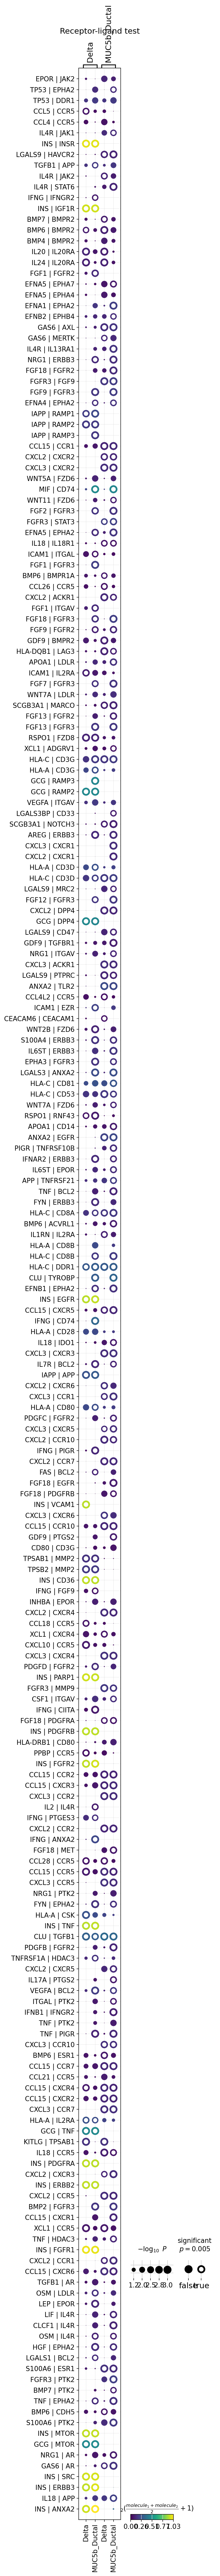

In [42]:
sq.pl.ligrec(res_10, alpha=0.005,remove_nonsig_interactions=True, remove_empty_interactions=True)

In [46]:
sq.pl.ligrec(res_12, alpha=0.005,remove_nonsig_interactions=False, remove_empty_interactions=True)

ValueError: After removing rows with only NaN interactions, none remain.

### NCEM

In [47]:
from ncem.tl.fit.glm import linear_ncem

In [48]:
adata_10 = linear_ncem(adata=adata_10, key_type='CellTypes_max', key_graph='spatial_connectivities')
adata_12 = linear_ncem(adata=adata_12, key_type='CellTypes_max', key_graph='spatial_connectivities')

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [49]:
adata_12.obs['CellTypes_max'].value_counts()

CellTypes_max
Acinar_highEnz        976
Acinar_sigdiff        798
Ductal                680
Acinar_basal          579
Acinar_signal         408
Alpha                 373
Activated_Stellate    242
Beta                  232
Endothelial           210
Quiescent_Stellate    194
Macrophage            152
Delta                 131
MUC5b_Ductal          127
Tcells                106
Name: count, dtype: int64

In [50]:
adata_10.obs['CellTypes_max'].value_counts()

CellTypes_max
Acinar_sigdiff        941
Acinar_highEnz        931
Ductal                561
Acinar_basal          368
Acinar_signal         362
Activated_Stellate    188
Quiescent_Stellate    184
Beta                  174
Endothelial           172
Alpha                 156
Tcells                128
Macrophage            102
MUC5b_Ductal           83
Delta                  73
Name: count, dtype: int64

In [51]:
adata_10, adata_12

(AnnData object with n_obs × n_vars = 4423 × 979
     obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'CellTypes_max'
     var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
     uns: 'CellTypes_max_colors', 'cell_type_coarse_colors', 'log1p', 'neighbors', 'pca', 'spatial', 'umap', 'spatial_neighbors', 'CellTypes_max_nhood_enrichment', 'CellTypes_max_interactions', 'Ce

#### Exploring interesting interactions

In [52]:
adata_10.varm['ncem_fdr_pvals']

index_Acinar_basal:neighbor_Acinar_basal  \
AATK                                      1.000000   
ABL1                                      1.000000   
ABL2                                      1.000000   
ACE                                       1.000000   
ACE2                                      1.000000   
...                                            ...   
NegPrb19                                  0.159521   
NegPrb20                                  1.000000   
NegPrb21                                  0.911532   
NegPrb22                                  0.216652   
NegPrb23                                  1.000000   

          index_Acinar_highEnz:neighbor_Acinar_basal  \
AATK                                        0.614619   
ABL1                                        1.000000   
ABL2                                        0.962217   
ACE                                         1.000000   
ACE2                                        1.000000   
...                                              ...   
NegPrb19                                    0.460155   
NegPrb20                                    1.000000   
NegPrb21                                    1.000000   
NegPrb22                                    0.963555   
NegPrb23                                    0.990416   

          index_Acinar_sigdiff:neighbor_Acinar_basal  \
AATK                                        1.000000   
ABL1                                        1.000000   
ABL2                                        0.521342   
ACE                                         1.000000   
ACE2                                        0.901678   
...                                              ...   
NegPrb19                                    1.000000   
NegPrb20                                    0.802320   
NegPrb21                                    0.940255   
NegPrb22                                    1.000000   
NegPrb23                                    1.000000   

          index_Acinar_signal:neighbor_Acinar_basal  \
AATK                                       1.000000   
ABL1                                       1.000000   
ABL2                                       1.000000   
ACE                                        1.000000   
ACE2                                       1.000000   
...                                             ...   
NegPrb19                                   1.000000   
NegPrb20                                   1.000000   
NegPrb21                                   1.000000   
NegPrb22                                   0.990639   
NegPrb23                                   1.000000   

          index_Activated_Stellate:neighbor_Acinar_basal  \
AATK                                            1.000000   
ABL1                                            1.000000   
ABL2                                            1.000000   
ACE                                             1.000000   
ACE2                                            1.000000   
...                                                  ...   
NegPrb19                                        1.000000   
NegPrb20                                        1.000000   
NegPrb21                                        0.918575   
NegPrb22                                        1.000000   
NegPrb23                                        1.000000   

          index_Alpha:neighbor_Acinar_basal  index_Beta:neighbor_Acinar_basal  \
AATK                               0.462572                          1.000000   
ABL1                               1.000000                          1.000000   
ABL2                               0.956078                          1.000000   
ACE                                1.000000                          1.000000   
ACE2                               1.000000                          1.000000   
...                                     ...                               ...   
NegPrb19                           1.000000                       

In [53]:
df = pd.DataFrame(np.sum(np.absolute(adata_10.varm['ncem_params'])))
df_int_10 = pd.DataFrame(columns=adata_10.obs['CellTypes_max'].cat.categories, index=adata_10.obs['CellTypes_max'].cat.categories,dtype=float)
for s in adata_10.obs['CellTypes_max'].cat.categories:
    for r in adata_10.obs['CellTypes_max'].cat.categories: 
        index_value = 'index_'+s+':neighbor_'+r
        df_int_10.at[s,r] = df.loc[index_value][0]
df_int_10

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Acinar_basal  Acinar_highEnz  Acinar_sigdiff  \
Acinar_basal           11.097920       15.147606       12.843494   
Acinar_highEnz          6.998560        9.058079        8.290781   
Acinar_sigdiff          7.455448        8.013859        9.557021   
Acinar_signal          11.229663       13.619795       14.359502   
Activated_Stellate     25.026886       28.216941       28.277717   
Alpha                  40.876811       31.108308       34.884675   
Beta                   34.696571       33.008699       32.275619   
Delta                  48.818478       61.977869       51.123606   
Ductal                 14.787113       15.078057       15.198919   
Endothelial            23.651119       27.198893       27.258336   
MUC5b_Ductal           41.790986       42.485783       40.709753   
Macrophage             31.350007       29.472911       32.337996   
Quiescent_Stellate     24.046977       24.982165       27.268972   
Tcells                 21.294099       27.817398       30.857972   

                    Acinar_signal  Activated_Stellate      Alpha       Beta  \
Acinar_basal            11.582750           14.340892  25.350536  21.378131   
Acinar_highEnz           6.997630            8.770506  14.613575  11.984789   
Acinar_sigdiff           7.025119            9.211629  12.341405  11.495906   
Acinar_signal           10.863526           14.236443  23.474619  20.763833   
Activated_Stellate      24.902098           27.016542  37.709381  37.632607   
Alpha                   42.722591           30.399872  40.543807  32.995006   
Beta                    32.918313           30.533027  24.672558  31.633226   
Delta                   50.222777           45.162295  51.079217  66.401817   
Ductal                  13.682814           17.764138  26.656107  21.969167   
Endothelial             22.669783           33.449681  38.346344  40.958831   
MUC5b_Ductal            37.875344           52.857463  75.392950  50.105928   
Macrophage              33.508991           36.017195  45.605350  48.230900   
Quiescent_Stellate      21.278966           23.951119  41.959142  35.958439   
Tcells                  24.652623           32.699072  38.457660  38.116817   

                        Delta     Ductal  Endothelial  MUC5b_Ductal  \
Acinar_basal        24.564975  11.801029    14.048377     22.133381   
Acinar_highEnz      15.069597   7.369499     8.142984     13.927096   
Acinar_sigdiff      16.947589   7.418190     8.146997     12.044154   
Acinar_signal       30.004962  12.131117    14.053538     20.528593   
Activated_Stellate  41.719150  28.335521    32.536366     52.560101   
Alpha               23.424036  34.451496    36.638249     86.373095   
Beta                24.534092  28.690188    35.423156     40.206631   
Delta               41.210382  46.274569    66.579083     70.853567   
Ductal              28.317558  17.813602    16.420458     19.929757   
Endothelial         48.915892  23.310578    23.739569     45.024927   
MUC5b_Ductal        74.727968  44.735492    41.839773     52.509478   
Macrophage          68.876604  31.567585    38.648135     49.807041   
Quiescent_Stellate  45.211606  23.515503    24.575510     36.030730   
Tcells              48.047655  23.296897    29.395663     53.381804   

                    Macrophage  Quiescent_Stellate     Tcells  
Acinar_basal         16.547784           14.614532  14.630172  
Acinar_highEnz       10.366058            8.738544   8.833454  
Acinar_sigdiff       10.578702            7.919579   9.233059  
Acinar_signal        18.437666           14.413465  16.125463  
Activated_Stellate   29.207505           27.310350  39.616052  
Alpha                36.929853           34.142042  37.693833  
Beta                 39.146124           31.034367  38.092558  
Delta                61.582927           57.029152  60.231479  
Ductal               18.048961           14.386917  17.733722  
Endothelial          32.220968           24.460578  25.519721  
MUC5b_Ductal         45.559896           43

In [54]:
df = pd.DataFrame(np.sum(np.absolute(adata_12.varm['ncem_params'])))
df_int_12 = pd.DataFrame(columns=adata_12.obs['CellTypes_max'].cat.categories, index=adata_12.obs['CellTypes_max'].cat.categories,dtype=float)
for s in adata_12.obs['CellTypes_max'].cat.categories:
    for r in adata_12.obs['CellTypes_max'].cat.categories: 
        index_value = 'index_'+s+':neighbor_'+r
        df_int_12.at[s,r] = df.loc[index_value][0]
df_int_12

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Acinar_basal  Acinar_highEnz  Acinar_sigdiff  \
Acinar_basal            9.946422       12.351375       10.502964   
Acinar_highEnz          7.366636        9.592413        7.315164   
Acinar_sigdiff          9.247267       10.414463        8.991387   
Acinar_signal          11.885268       15.068264       12.471463   
Activated_Stellate     22.946657       23.049113       23.953409   
Alpha                  44.138349       26.430073       26.162059   
Beta                   42.141840       34.911464       43.999360   
Delta                  44.156242       40.643356       41.297455   
Ductal                 13.446519       14.652833       13.050305   
Endothelial            23.118262       24.182416       24.708564   
MUC5b_Ductal           31.148645       36.999827       32.558426   
Macrophage             25.033137       31.938503       27.140008   
Quiescent_Stellate     22.565634       26.711313       26.384374   
Tcells                 28.830672       28.880968       32.305456   

                    Acinar_signal  Activated_Stellate      Alpha       Beta  \
Acinar_basal             9.521403           12.026653  26.862829  25.123176   
Acinar_highEnz           7.367597            9.325075  18.071066  17.170414   
Acinar_sigdiff           8.338251           10.557049  20.709722  18.207119   
Acinar_signal           11.649245           14.193504  33.142586  29.537233   
Activated_Stellate      22.685588           24.968907  37.758063  33.092387   
Alpha                   37.282345           21.906399  43.485872  15.517694   
Beta                    47.927463           33.913795  27.681723  35.483228   
Delta                   47.219372           40.443311  41.944569  32.351483   
Ductal                  13.224185           15.115191  29.012310  23.939306   
Endothelial             21.369349           24.338122  52.061258  35.543862   
MUC5b_Ductal            33.966957           35.793890  60.014676  52.141358   
Macrophage              27.203453           30.285070  59.806063  39.539403   
Quiescent_Stellate      24.415567           25.106431  40.598131  44.924417   
Tcells                  29.630298           32.872907  53.391093  49.422215   

                        Delta     Ductal  Endothelial  MUC5b_Ductal  \
Acinar_basal        20.828670   9.677581    11.564814     15.107551   
Acinar_highEnz      15.376363   6.895939     8.748371     11.960183   
Acinar_sigdiff      18.208995   8.337256     9.620282     14.150724   
Acinar_signal       28.709892  11.760054    13.868465     20.606700   
Activated_Stellate  36.327514  25.673748    23.730255     37.166317   
Alpha               12.363225  36.264755    23.058715     60.686619   
Beta                19.510641  37.997592    36.036289     52.292394   
Delta               33.986052  44.747405    33.522871     55.051515   
Ductal              26.714292  16.591697    15.317141     17.345651   
Endothelial         40.982425  24.778587    24.502449     39.433725   
MUC5b_Ductal        40.729071  31.116345    36.205724     48.674806   
Macrophage          41.604212  29.230550    32.220320     44.918310   
Quiescent_Stellate  50.884799  24.063844    27.121867     35.275870   
Tcells              48.613456  29.798639    31.353088     40.512702   

                    Macrophage  Quiescent_Stellate     Tcells  
Acinar_basal         12.972492           12.345075  14.489884  
Acinar_highEnz        9.662010            8.749273  11.030520  
Acinar_sigdiff       10.906213            9.659125  11.949201  
Acinar_signal        15.639709           14.938815  18.356217  
Activated_Stellate   29.057946           23.995740  32.462281  
Alpha                36.973288           19.828303  44.293759  
Beta                 37.739814           38.363770  48.135968  
Delta                41.336078           50.627755  52.482385  
Ductal               15.545289           14.732925  17.617226  
Endothelial          27.469695           25.703004  28.916531  
MUC5b_Ductal         38.611869           35

In [55]:
import seaborn as sns

<Axes: >

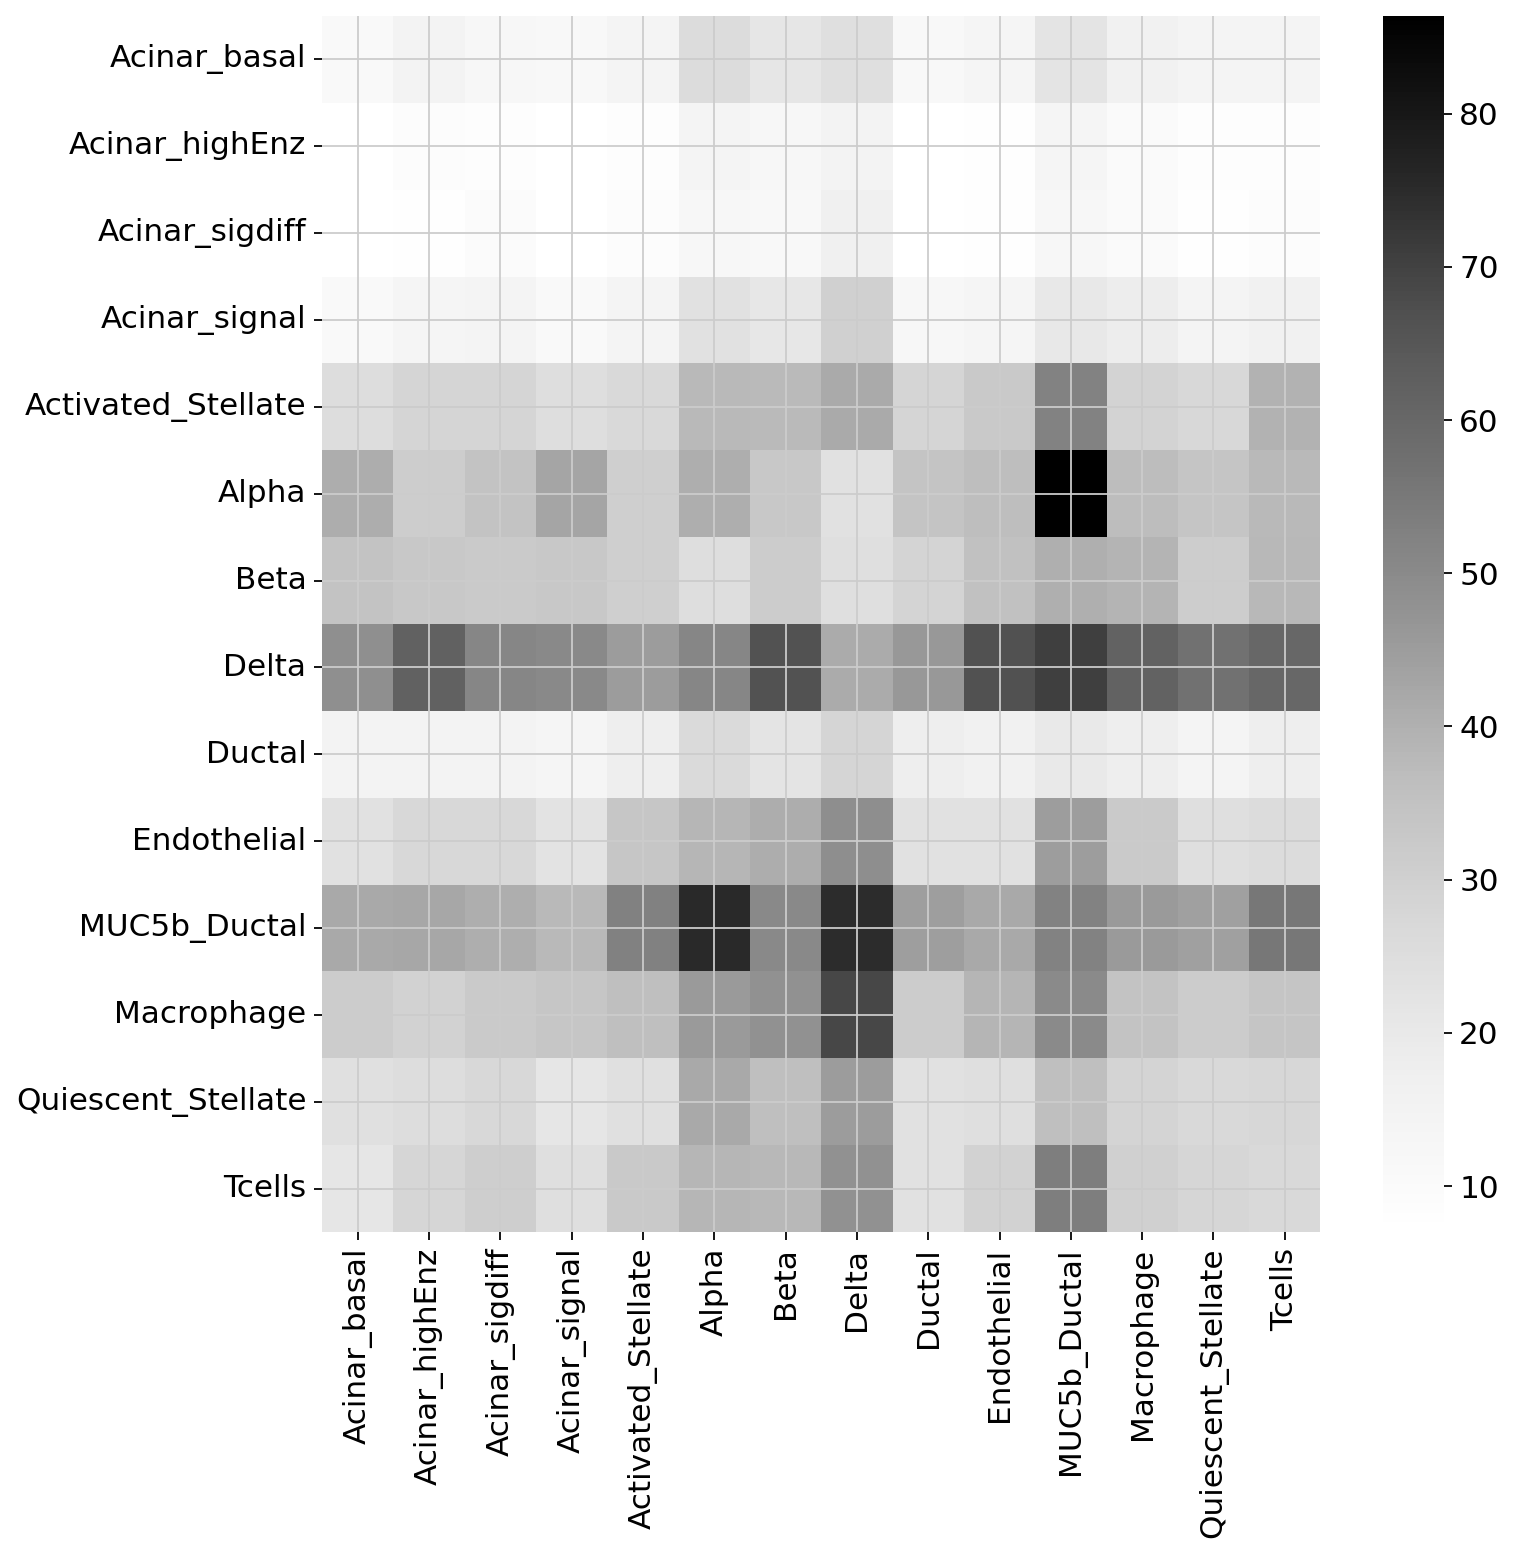

In [56]:
plt.figure(figsize=(10, 10))
sns.heatmap(df_int_10,cmap="Greys")

<Axes: >

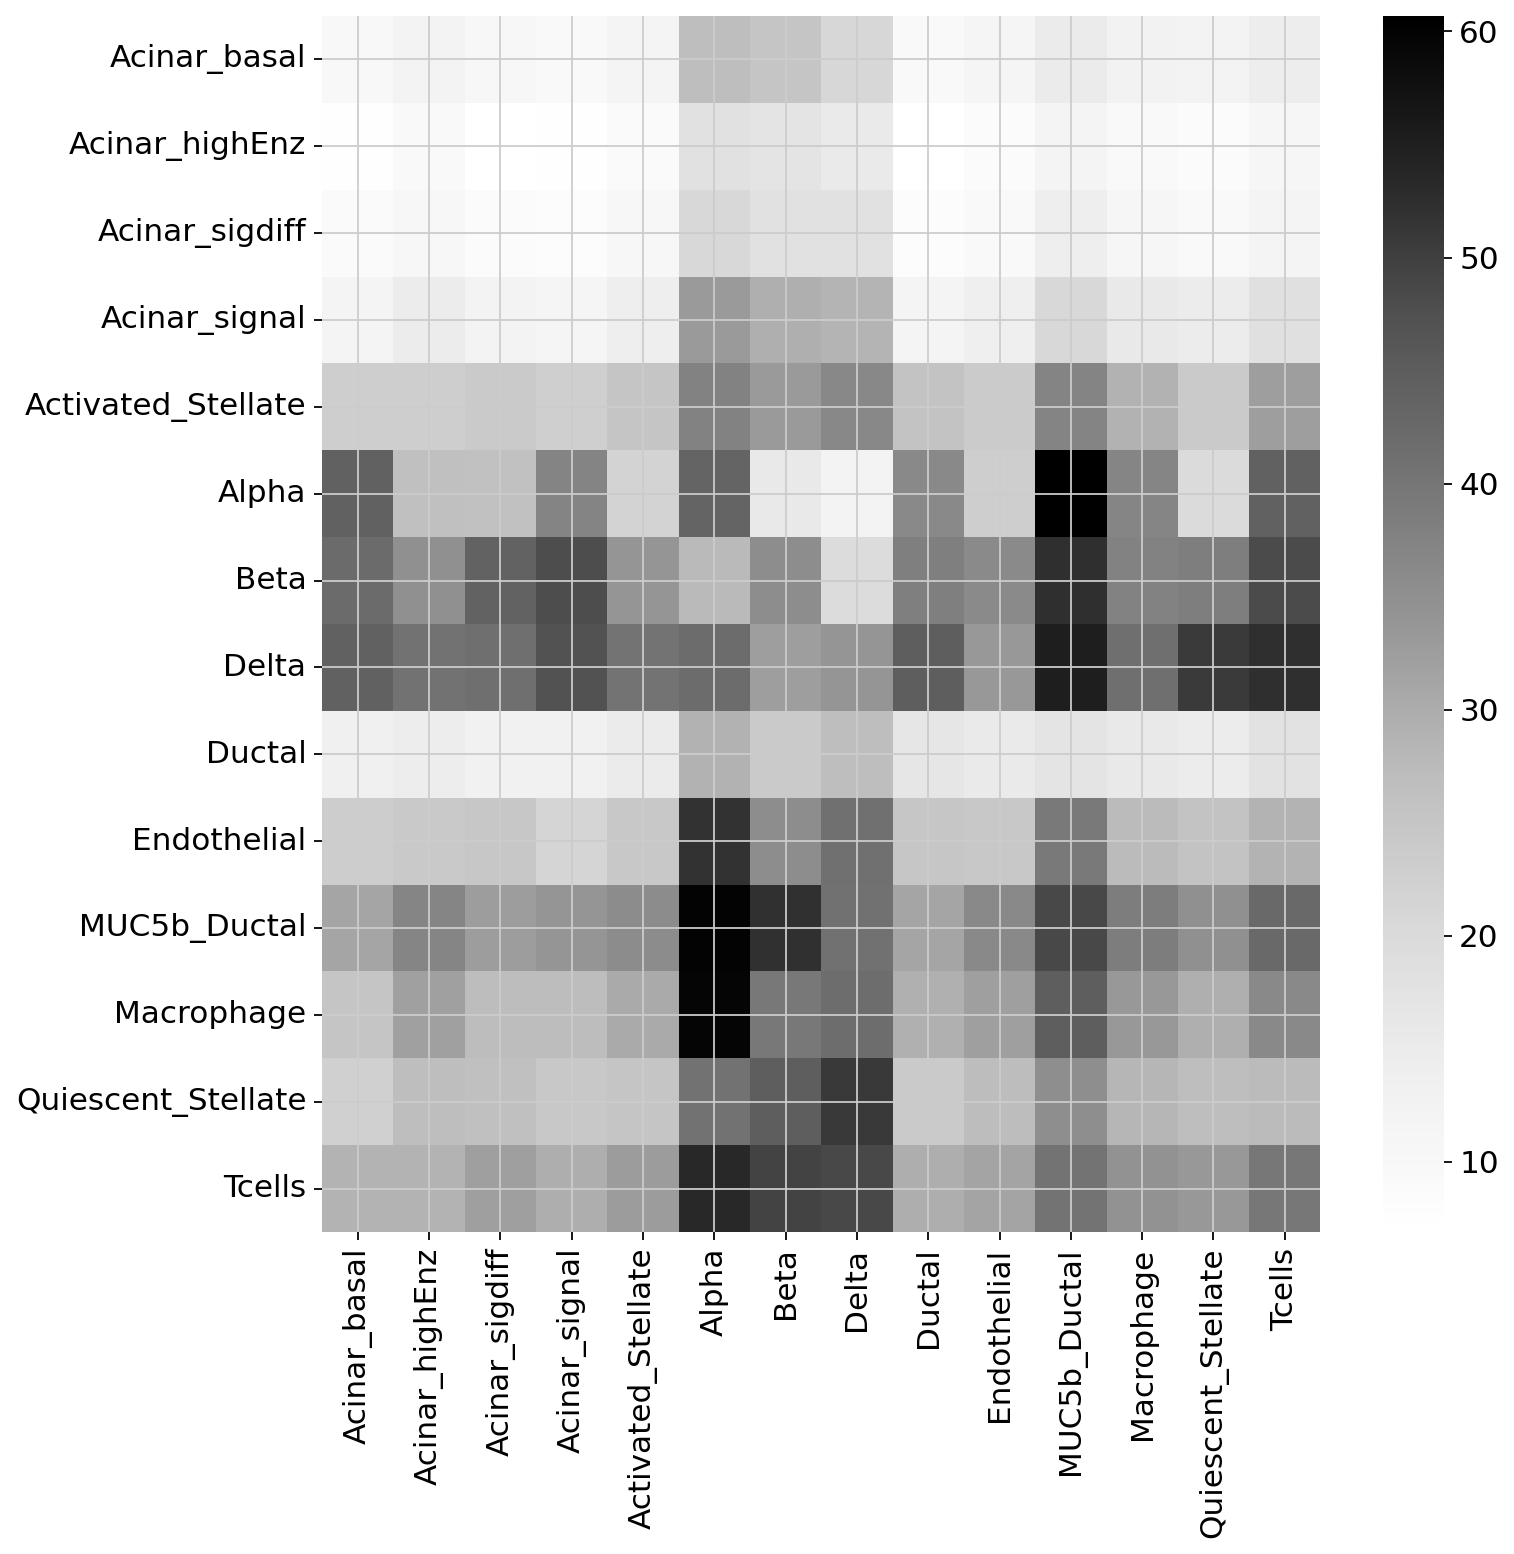

In [57]:
plt.figure(figsize=(10, 10))
sns.heatmap(df_int_12,cmap="Greys")

In [104]:
interactions = [
    'index_Alpha:neighbor_MUC5b_Ductal' #ND
    #'index_Beta:neighbor_MUC5b_Ductal' #ND
    #'index_Delta:neighbor_MUC5b_Ductal' #ND
    #'index_Endothelial:neighbor_Alpha' #ND
    #'index_MUC5b_Ductal:neighbor_Alpha' #ND
    #'index_Macrophage:neighbor_Alpha' #ND
    #'index_Tcells:neighbor_Alpha' #ND
]

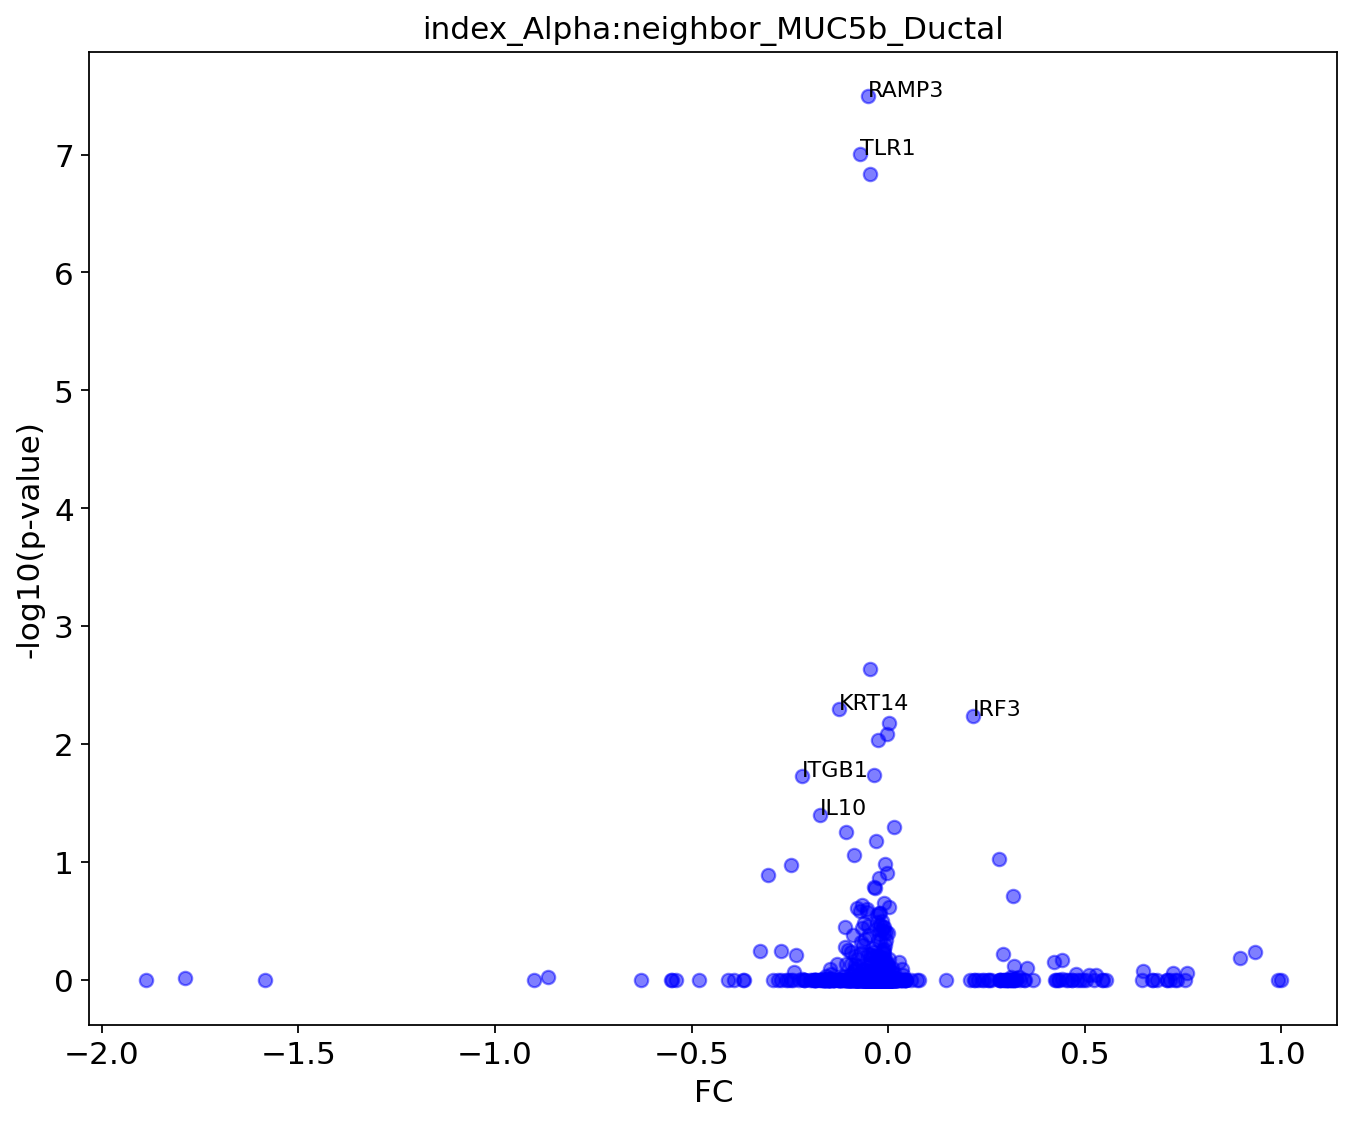

In [105]:
adata = adata_10.copy()
for c in interactions:
    data_df = {
        'log2FoldChange' : adata.varm['ncem_params'][c],
        'padj' : adata.varm['ncem_fdr_pvals'][c],
        'symbol' : np.array(adata.varm['ncem_fdr_pvals'].index)
    }
    
    df = pd.DataFrame(data_df)
    
    df['-log10(p_value)'] = -np.log10(df['padj'])
    

    plt.figure(figsize=(10, 8))
    plt.scatter(df['log2FoldChange'], df['-log10(p_value)'], color='blue', alpha=0.5)
    
    # Label the most significant points
    threshold_logFC = 0.05  # Adjust as needed
    threshold_p_value = 0.05  # Adjust as needed
    significant_points = df[(abs(df['log2FoldChange']) >= threshold_logFC) & (df['padj'] <= threshold_p_value)]
    for i, point in significant_points.iterrows():
        plt.text(point['log2FoldChange'], point['-log10(p_value)'], point['symbol'], fontsize=10)
        #volcano(df)
        
    # Add labels and title
    plt.xlabel('FC')
    plt.ylabel('-log10(p-value)')
    plt.title(c)
    
    # Show plot
    plt.grid(False)
    plt.show()

In [106]:
df

log2FoldChange      padj    symbol  -log10(p_value)
AATK           -0.094351  0.733427      AATK         0.134643
ABL1           -0.080839  0.988901      ABL1         0.004847
ABL2           -0.164511  1.000000      ABL2        -0.000000
ACE            -0.026037  1.000000       ACE        -0.000000
ACE2            0.009016  0.862261      ACE2         0.064362
...                  ...       ...       ...              ...
NegPrb19        0.002513  0.926138  NegPrb19         0.033324
NegPrb20       -0.059637  1.000000  NegPrb20        -0.000000
NegPrb21        0.002354  0.006606  NegPrb21         2.180060
NegPrb22       -0.000080  1.000000  NegPrb22        -0.000000
NegPrb23       -0.025559  1.000000  NegPrb23        -0.000000

[979 rows x 4 columns]

In [107]:
#significant_points = df[(abs(df['log2FoldChange']) >= threshold_logFC) & (df['padj'] <= threshold_p_value)]
sp = significant_points.dropna().sort_values('-log10(p_value)', ascending=False)
# Replace infinite values with NaN
sp.replace([np.inf, -np.inf], np.nan, inplace=True)
sp.dropna(inplace=True)
sp

log2FoldChange          padj symbol  -log10(p_value)
RAMP3       -0.050516  3.190725e-08  RAMP3         7.496111
TLR1        -0.071500  9.931701e-08   TLR1         7.002976
KRT14       -0.125877  5.054800e-03  KRT14         2.296296
IRF3         0.215513  5.709580e-03   IRF3         2.243396
ITGB1       -0.219684  1.862798e-02  ITGB1         1.729834
IL10        -0.174160  3.946955e-02   IL10         1.403738

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/scanpy/plotting/_matrixplot.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


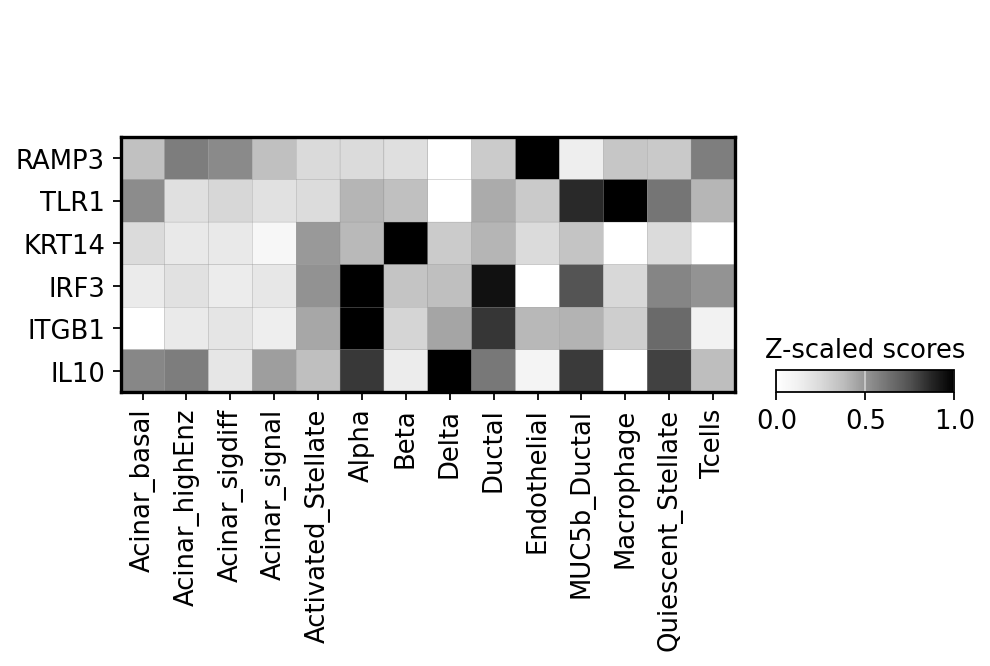

In [108]:
sc.pl.matrixplot(adata_10, sp['symbol'], 'CellTypes_max', dendrogram=False, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='Greys', swap_axes=True)